# Exploratory Data Analysis: Fase 2

## Indice
1. [Importaciones y contexto](#importaciones-y-contexto)
2. [An√°lisis Univariante](#analisis-univariante)
    - [Variables num√©ricas](#variables-numericas)
    - [Variables categ√≥ricas](#variables-categoricas)
3. [An√°lisis Bivariante](#analisis-bivariante)
    - [Variables num√©ricas](#variables-numericas-vs-target)
    - [Variables Categ√≥ricas](#variables-categoricas-vs-target)

4. [Guardado de features](#guardado-final-de-features)
    - [Definici√≥n de features finales](#definici√≥n)


# Importaciones y contexto

In [30]:
# =========================
# Importaci√≥n de librer√≠as
# =========================

# --- Sistema y rutas ---
import os
import sys
utils_path = os.path.abspath("../utils")  # A√±adir ruta de m√≥dulos auxiliares
sys.path.append(utils_path)

# --- Manipulaci√≥n de datos ---
import pandas as pd
import numpy as np
import math


# --- Visualizaci√≥n ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Soporte y an√°lisis ---
import warnings

# --- M√≥dulos propios ---
import eda as eda  # Funciones personalizadas del proyecto

# --- Configuraci√≥n global ---
warnings.filterwarnings('ignore')  # Ignorar warnings innecesarios


In [31]:
import importlib
importlib.reload(eda)

<module 'eda' from 'c:\\Users\\javie\\Documents\\Portafolio_DS\\ToxiPredict\\src\\utils\\eda.py'>

In [32]:
# Dataset de entrenamiento
df_trainval = pd.read_csv("../../data/interim/trainval.csv")

# Visualizaci√≥n
df_trainval.head()

test_id  reference_number    test_cas test_location test_exposure_type  \
0  1001265               182     94-09-7           LAB                  S   
1  1001266               182     94-09-7           LAB                  S   
2  1001694               225  52918-63-5           LAB                  S   
3  1001695               225  52918-63-5           LAB                  S   
4  1001696               225  52918-63-5           LAB                  S   

  test_control_type test_media_type test_application_freq_unit  \
0                 I              FW                          X   
1                 I              FW                          X   
2                 I              FW                          X   
3                 I              FW                          X   
4                 I              FW                          X   

  test_organism_lifestage  result_id  ... split_random split_occurrence  \
0                      NR     112643  ...            3                2   
1                      NR     112644  ...            3                2   
2                      NR     111395  ...            3                2   
3                      NR     111396  ...            3                2   
4                      NR     111397  ...            3                2   

   split_scaffold-murcko split_scaffold-murcko-loo-0  \
0                      4                        test   
1                      4                        test   
2                      2                  trainvalid   
3                      2                  trainvalid   
4                      2                  trainvalid   

  split_scaffold-murcko-loo-1  split_scaffold-murcko-llo  \
0                  trainvalid                 trainvalid   
1                  trainvalid                 trainvalid   
2                  trainvalid                 trainvalid   
3                  trainvalid                 trainvalid   
4                  trainvalid                 trainvalid   

   split_scaffold-generic  split_scaffold-generic-loo-0  \
0                       4                          test   
1                       4                          test   
2                       2                    trainvalid   
3                       2                    trainvalid   
4                       2                    trainvalid   

   split_scaffold-generic-loo-1 split_scaffold-generic-llo  
0                    trainvalid                 trainvalid  
1                    trainvalid                 trainvalid  
2                    trainvalid                 trainvalid  
3                    trainvalid                 trainvalid  
4                    trainvalid                 trainvalid  

[5 rows x 1106 columns]

In [33]:
# Nombre de la variable objetivo
target = "result_conc1_mean_binary"

# Separaci√≥n
X_train = df_trainval.drop(columns=target).copy()
y_train = df_trainval[target].copy()

In [34]:
# Lectura de la plantilla de an√°lisis resultante del notebook de trabajo previo (02_Variables_Features)
plantilla_analisis = pd.read_csv("../../data/interim/plantilla_analisis_final.csv", index_col=0)

In [35]:
# asegurar que las top features de RF est√©n marcadas como 'mantener'

# Cargar top features de Random Forest
top_rf = pd.read_csv("../../data/interim/features_rf.csv").head(20)

# Extraer el nombre original de cada variable (quitar prefijos como 'standardscaler__')
top_rf["nombre_variable"] = top_rf["feature"].apply(lambda x: x.split("__")[-1])

# Forzar que est√©n marcadas como mantener en la plantilla
plantilla_analisis.loc[
    plantilla_analisis["nombre_variable"].isin(top_rf["nombre_variable"]),
    ["expectativas", "conclusion"]
] = ["alta (RF)", "mantener"]


In [36]:
# 1. Filtrado de variables v√°lidas para EDA

# Selecci√≥n de las variables marcadas como "mantener"
vars_mantener = plantilla_analisis.query("conclusion == 'mantener'")["nombre_variable"].tolist()

# Nuevo DataFrame solo con esas columnas
X_train_validadas = X_train[vars_mantener].copy()
print(f"Variables seleccionadas para EDA: {len(vars_mantener)}\n")

Variables seleccionadas para EDA: 613



In [37]:
# 2. Separaci√≥n por tipo de variable

# Separar en num√©ricas y categ√≥ricas 
vars_numericas = X_train_validadas.select_dtypes(include=['float64', 'int64']).columns.tolist()
vars_categoricas = X_train_validadas.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print(f"Variables num√©ricas: {len(vars_numericas)}")
print(f"Variables categ√≥ricas: {len(vars_categoricas)}")

# Vista previa r√°pida
X_train_validadas[vars_numericas].describe().T.round(2)


Variables num√©ricas: 592
Variables categ√≥ricas: 21


count   mean    std    min    25%    50%     75%  \
result_obs_duration_mean  21981.0  67.52  31.03  24.00  24.00  96.00   96.00   
media_ph_mean             13669.0   7.50   0.55   3.00   7.20   7.40    7.80   
media_temperature_mean    16468.0  18.75   5.88   1.60  12.00  20.00   24.60   
tax_ps_ampv               21981.0   0.04   0.03   0.01   0.02   0.04    0.06   
tax_ps_ampkap             21981.0   0.77   0.20   0.34   0.62   0.75    0.94   
...                           ...    ...    ...    ...    ...    ...     ...   
chem_mordred_AMW          21981.0  10.24   4.28   4.31   7.36   9.09   11.72   
chem_mordred_WPol         21981.0  21.95  13.18   0.00  13.00  21.00   30.00   
chem_mordred_Zagreb1      21981.0  75.82  37.04   2.00  54.00  72.00   98.00   
chem_mordred_Zagreb2      21981.0  87.65  48.50   1.00  56.00  80.00  112.00   
chem_mordred_mZagreb2     21981.0   3.50   1.34   0.75   2.67   3.47    4.37   

                             max  
result_obs_duration_mean   96.00  
media_ph_mean              10.00  
media_temperature_mean     40.00  
tax_ps_ampv                 0.22  
tax_ps_ampkap               1.00  
...                          ...  
chem_mordred_AMW           49.95  
chem_mordred_WPol         104.00  
chem_mordred_Zagreb1      230.00  
chem_mordred_Zagreb2      323.00  
chem_mordred_mZagreb2       9.08  

[592 rows x 8 columns]

 Hay 604 variables marcadas como "mantener". Analizarlas todas manualmente ser√≠a inviable y contraproducente. La mejor estrategia para priorizar es:

- Priorizar las m√°s relevantes seg√∫n modelos previos
    - `RandomForestClassifier.feature_importances_`
    - `SelectKBest `

Estrategia:
Crear un ranking combinado y seleccionar el top 20 de cada tipo (num√©ricas y categ√≥ricas).

In [38]:
# Priorizaci√≥n de variables por importancia combinada

# 1. Cargar archivos con rankings
rf = pd.read_csv("../../data/interim/features_rf.csv")
kbest = pd.read_csv("../../data/interim/features_kbest.csv")

# 2. Limpiar nombres de variables transformadas en RF
rf["nombre_variable"] = rf["feature"].apply(lambda x: x.split("__")[-1])

# 3. Calcular rankings individuales
rf["ranking_rf"] = rf["importance"].rank(ascending=False).astype(int)
kbest["ranking_kbest"] = kbest["score_f"].rank(ascending=False).astype(int)

# 4. Unir rankings por nombre original
df_merge = pd.merge(
    rf[["nombre_variable", "ranking_rf"]],
    kbest[["nombre_variable", "ranking_kbest"]],
    on="nombre_variable",
    how="outer"
)

# 5. Definir variables a analizar (Top RF + KBest + prioritarias)
prioritarias = [
    "tax_gs",                   
    "test_exposure_type",
    "test_organism_lifestage",
    "result_endpoint",
    "tax_family",
    "tax_eco_migrate2"
]
top_rf = rf["nombre_variable"].tolist()
top_kbest = kbest["nombre_variable"].tolist()
vars_analizar = list(set(top_rf + top_kbest + prioritarias))

# 6. Filtrar y ordenar por ranking combinado
df_merge["ranking_combinado"] = df_merge[["ranking_rf", "ranking_kbest"]].min(axis=1)
df_ordenadas = df_merge[df_merge["nombre_variable"].isin(vars_analizar)].copy()
df_ordenadas = df_ordenadas.sort_values("ranking_combinado").reset_index(drop=True)

# 7. Lista final ordenada de variables
vars_analizar_ordenadas = df_ordenadas["nombre_variable"].tolist()

# 8. Asegurar que las prioritarias est√©n incluidas
for var in prioritarias:
    if var not in vars_analizar_ordenadas:
        vars_analizar_ordenadas.append(var)

# 9. Visualizar resumen
print(f"Variables ordenadas para an√°lisis (incluyendo prioritarias): {len(vars_analizar_ordenadas)}")


Variables ordenadas para an√°lisis (incluyendo prioritarias): 46


### Priorizaci√≥n de variables por importancia combinada

Para facilitar la interpretaci√≥n y optimizar el tiempo de an√°lisis, las variables seleccionadas por Random Forest (`importance`) y SelectKBest (`score_f`) se han ordenado de forma descendente seg√∫n su relevancia respecto al target.

Se ha calculado un ranking combinado, conservando tambi√©n variables marcadas como prioritarias por conocimiento experto (como `tax_gs`). Esto permite centrar el an√°lisis univariante y bivariante en las variables m√°s prometedoras y representativas del dataset.

### Justificaci√≥n de inclusi√≥n de variables categ√≥ricas prioritarias

Aunque muchas de las siguientes variables categ√≥ricas no fueron seleccionadas autom√°ticamente como las m√°s relevantes por m√©todos como Random Forest o SelectKBest, se han incluido manualmente en el an√°lisis por su **alto valor contextual, regulatorio y biol√≥gico**:

- `test_exposure_type`  
- `test_organism_lifestage`  
- `result_endpoint`  
- `tax_class`, `tax_order`, `tax_family`  
- `tax_eco_migrate2`

Estas variables fueron priorizadas por las siguientes razones:

#### Relevancia experimental o ecol√≥gica
Permiten capturar diferencias clave en los **tipos de prueba** (aguda vs. cr√≥nica), **etapa de desarrollo** del organismo (larva, adulto...), y **especificidades taxon√≥micas** que pueden afectar la toxicidad.

#### Interpretabilidad cient√≠fica
Su an√°lisis facilita entender el comportamiento del modelo seg√∫n **familias taxon√≥micas**, **tipos de endpoint** o **caracter√≠sticas biol√≥gicas** relevantes en ecotoxicolog√≠a.

#### Control de sesgo y generalizaci√≥n
La inclusi√≥n expl√≠cita de estas variables permite detectar sesgos o patrones asociados a ciertas condiciones biol√≥gicas o experimentales. Adem√°s, mejora la **capacidad de generalizaci√≥n** si se entrena el modelo con datos de distintas especies o tipos de prueba.

> Por estas razones, estas variables han sido marcadas como *prioritarias* en esta fase del an√°lisis exploratorio, y ser√°n evaluadas para su posible inclusi√≥n en el modelo predictivo final, independientemente de su ranking en m√©todos autom√°ticos.


# Analisis univariante
[Indice](#indice)

## Variables numericas

Exploramos la distribuci√≥n de las variables m√°s representativas, comenzando por las variables num√©ricas.

Se buscar√°n patrones de asimetr√≠a, presencia de outliers, concentraciones extremas o valores dominantes que puedan afectar al modelado.

In [39]:
# Filtrar solo las variables num√©ricas que aparecen en el ranking ordenado
vars_num_analizar = [var for var in vars_analizar_ordenadas if var in vars_numericas]

print(f"N√∫mero de variables num√©ricas a analizar: {len(vars_num_analizar)}")

N√∫mero de variables num√©ricas a analizar: 39


In [40]:
# Clasificamos las variables seg√∫n su familia
def clasificar_variable(nombre):
    if nombre.startswith("chem_mordred_"):
        return "mordred"
    elif nombre.startswith("chem_mol2vec"):
        return "mol2vec"
    elif nombre.startswith("tax_"):
        return "tax"
    elif nombre.startswith("media_"):
        return "media"
    elif nombre.startswith("result_"):
        return "result"
    else:
        return "otros"

# DataFrame con clasificaci√≥n
resumen_final_39 = pd.DataFrame({
    "Variable": vars_num_analizar,
    "Familia": [clasificar_variable(v) for v in vars_num_analizar]
})

# Diccionario de grupos
grupos_variables = {
    familia: resumen_final_39[resumen_final_39["Familia"] == familia]["Variable"].tolist()
    for familia in resumen_final_39["Familia"].unique()
}

grupos_variables

{'media': ['media_ph_mean', 'media_temperature_mean'],
 'mordred': ['chem_mordred_Zagreb1',
  'chem_mordred_TSRW10',
  'chem_mordred_ATSC0d',
  'chem_mordred_TMWC10',
  'chem_mordred_Xpc-6d',
  'chem_mordred_mZagreb2',
  'chem_mordred_ATS3Z',
  'chem_mordred_Xpc-6dv',
  'chem_mordred_SRW05',
  'chem_mordred_Xpc-5dv',
  'chem_mordred_Sm',
  'chem_mordred_SRW02',
  'chem_mordred_SRW07',
  'chem_mordred_ATS0m',
  'chem_mordred_SRW04',
  'chem_mordred_GGI2',
  'chem_mordred_JGI10',
  'chem_mordred_MWC07',
  'chem_mordred_Xpc-4dv',
  'chem_mordred_SRW06',
  'chem_mordred_MWC08',
  'chem_mordred_MWC09',
  'chem_mordred_MWC10',
  'chem_mordred_SRW03',
  'chem_mordred_MPC8',
  'chem_mordred_NssssC'],
 'result': ['result_obs_duration_mean'],
 'mol2vec': ['chem_mol2vec061',
  'chem_mol2vec012',
  'chem_mol2vec057',
  'chem_mol2vec226'],
 'tax': ['tax_lh_licm',
  'tax_ps_ampv',
  'tax_lh_amd',
  'tax_lh_lpcm',
  'tax_lh_ri#/d',
  'tax_ps_ampkap']}

In [41]:
# Crear el DataFrame con variables num√©ricas a analizar 
df_modelo = X_train_validadas[vars_num_analizar].copy()

Visualizando grupo: media con 2 variables


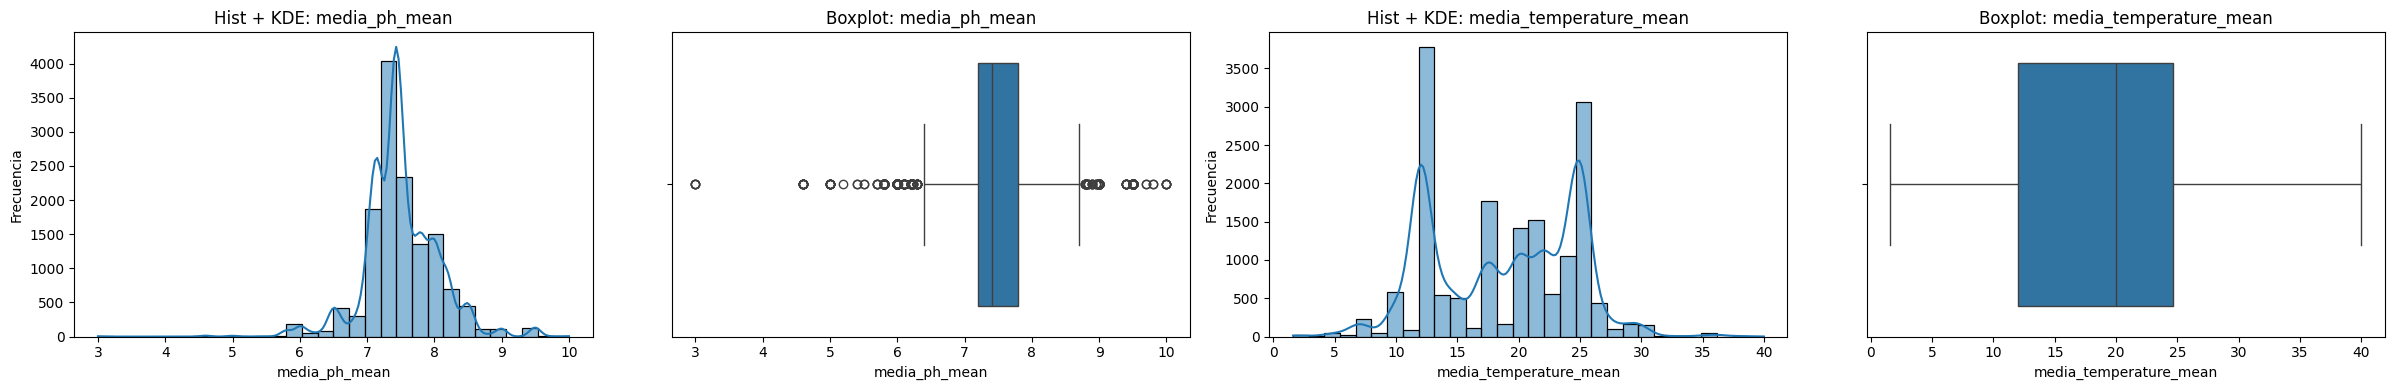

Visualizando grupo: mordred con 26 variables


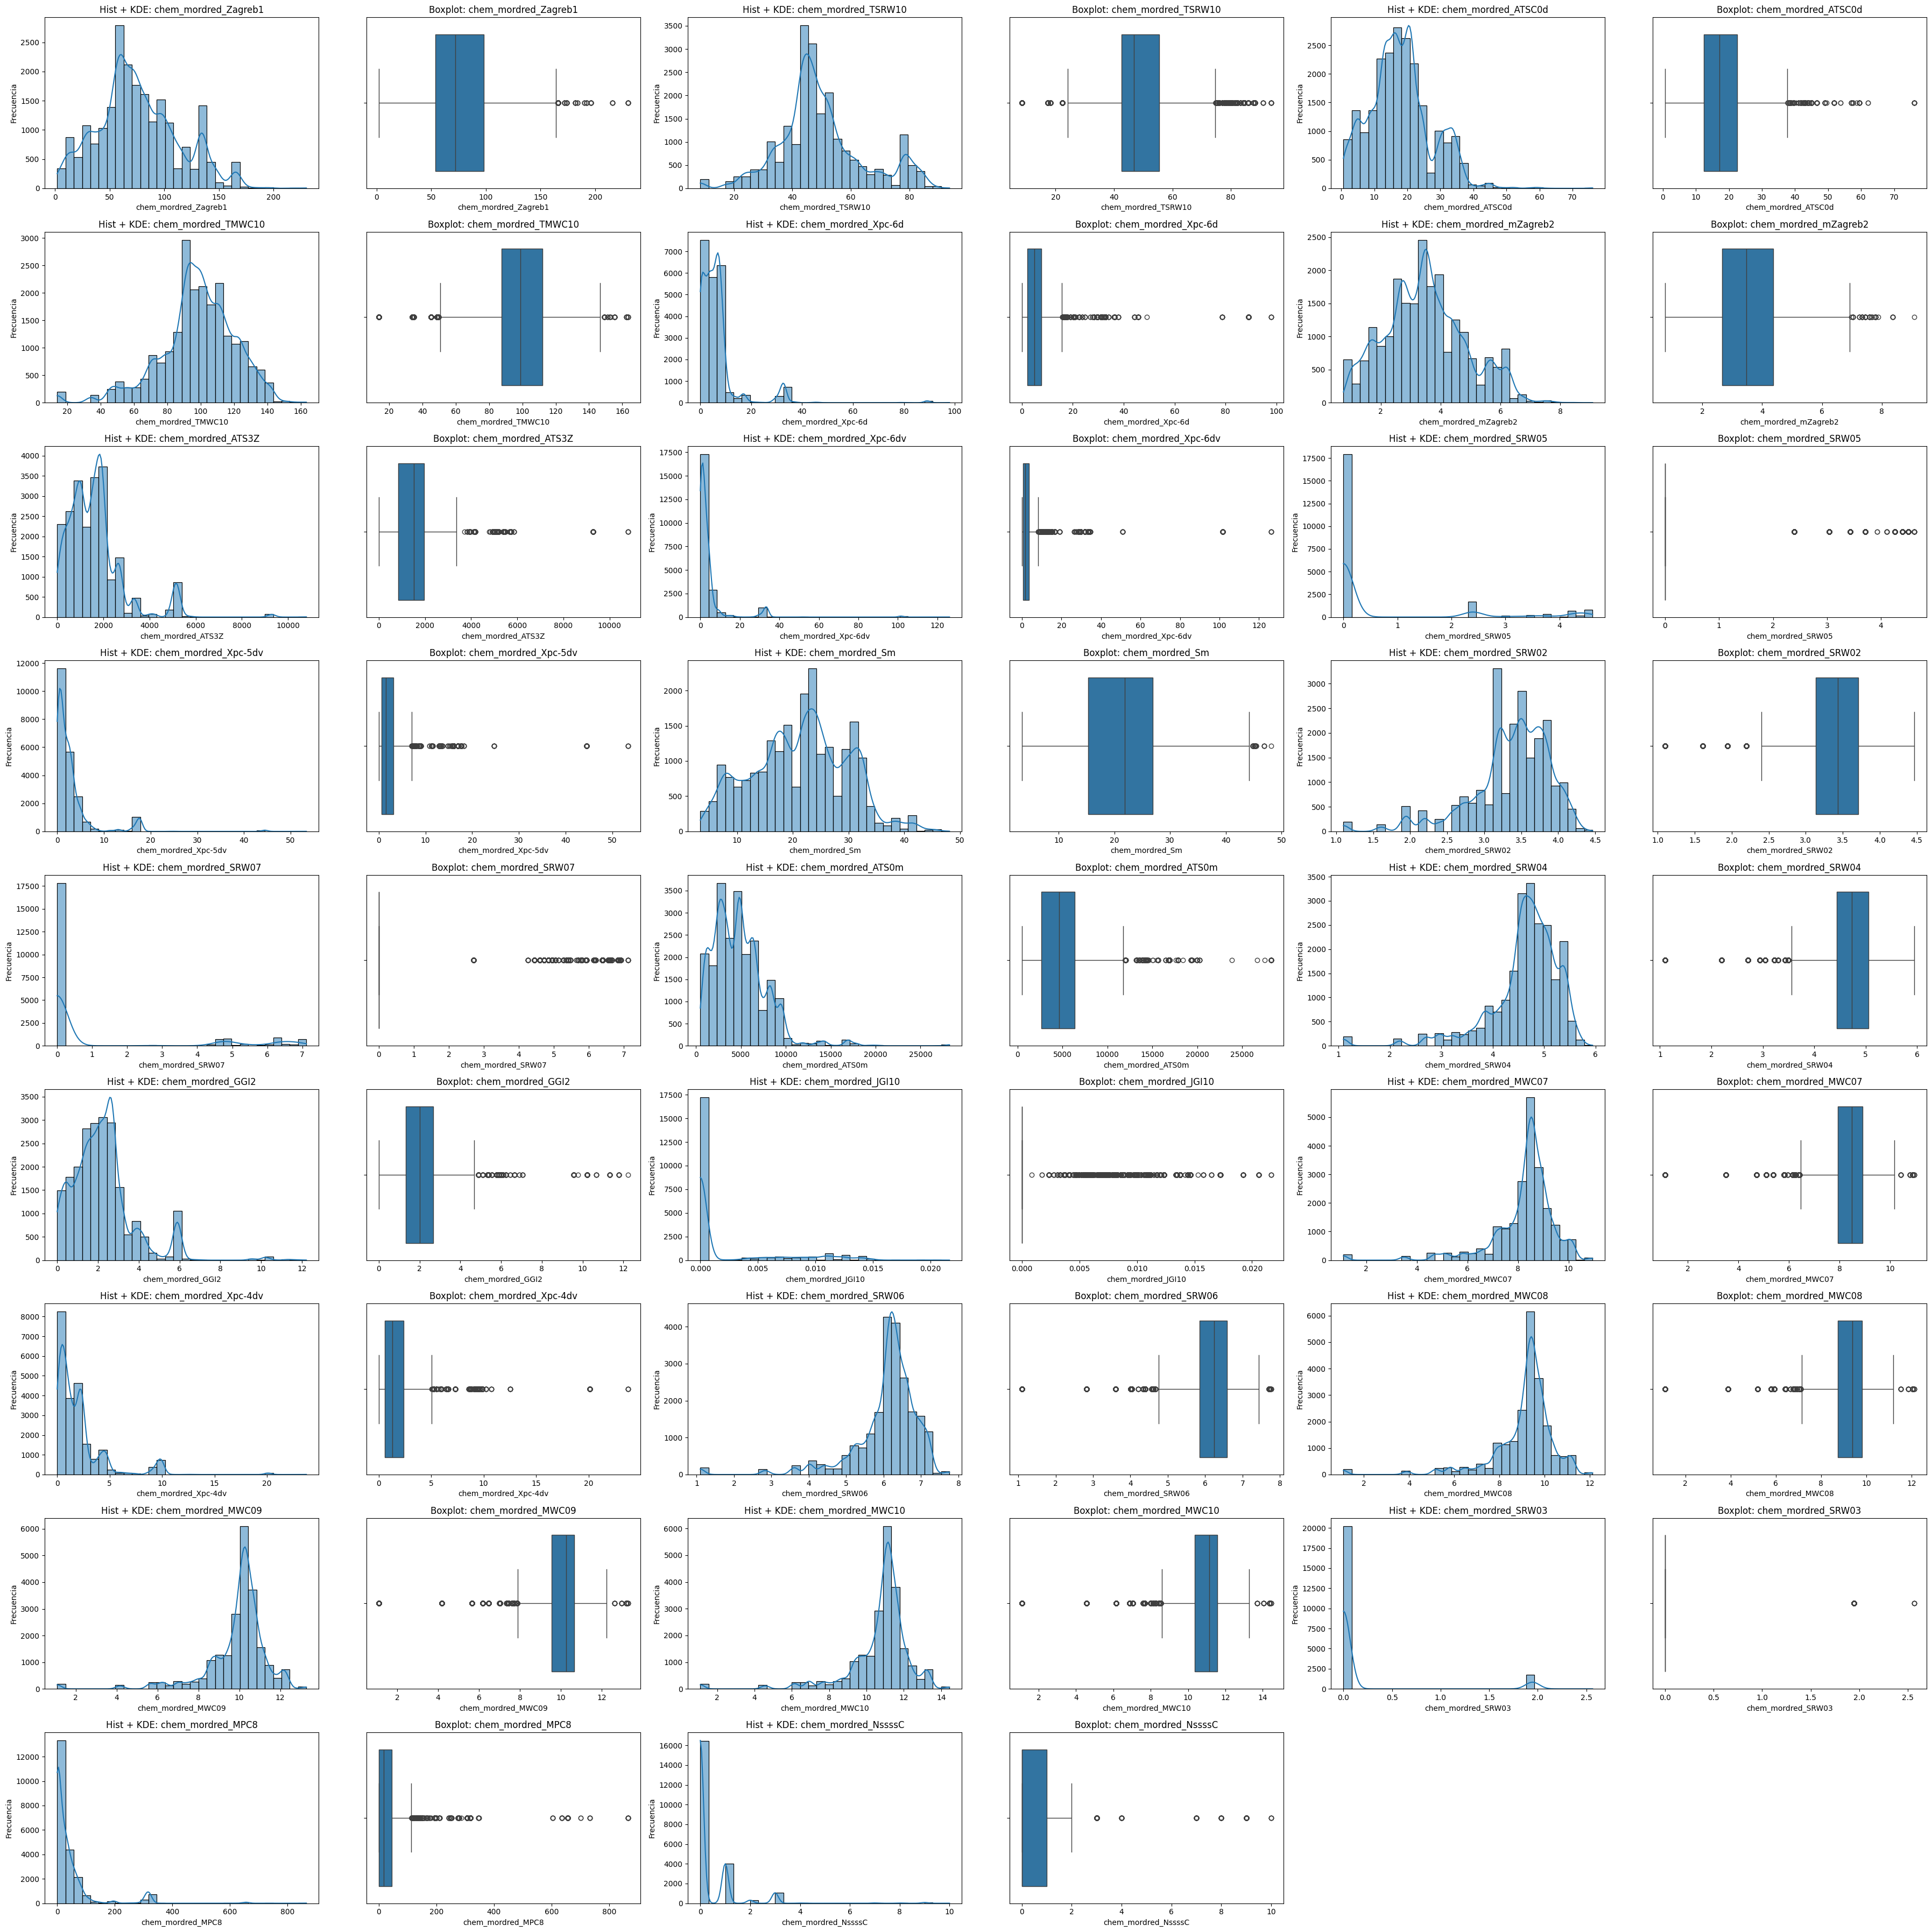

Visualizando grupo: result con 1 variables


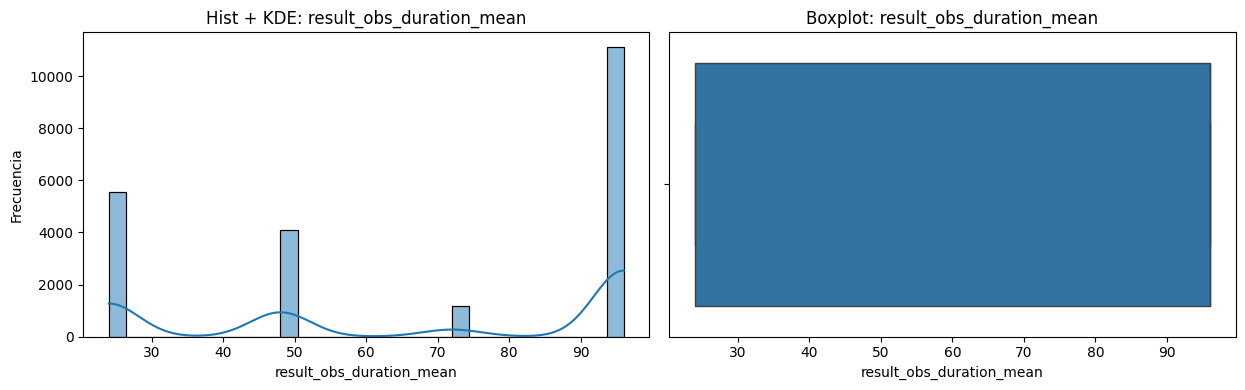

Visualizando grupo: mol2vec con 4 variables


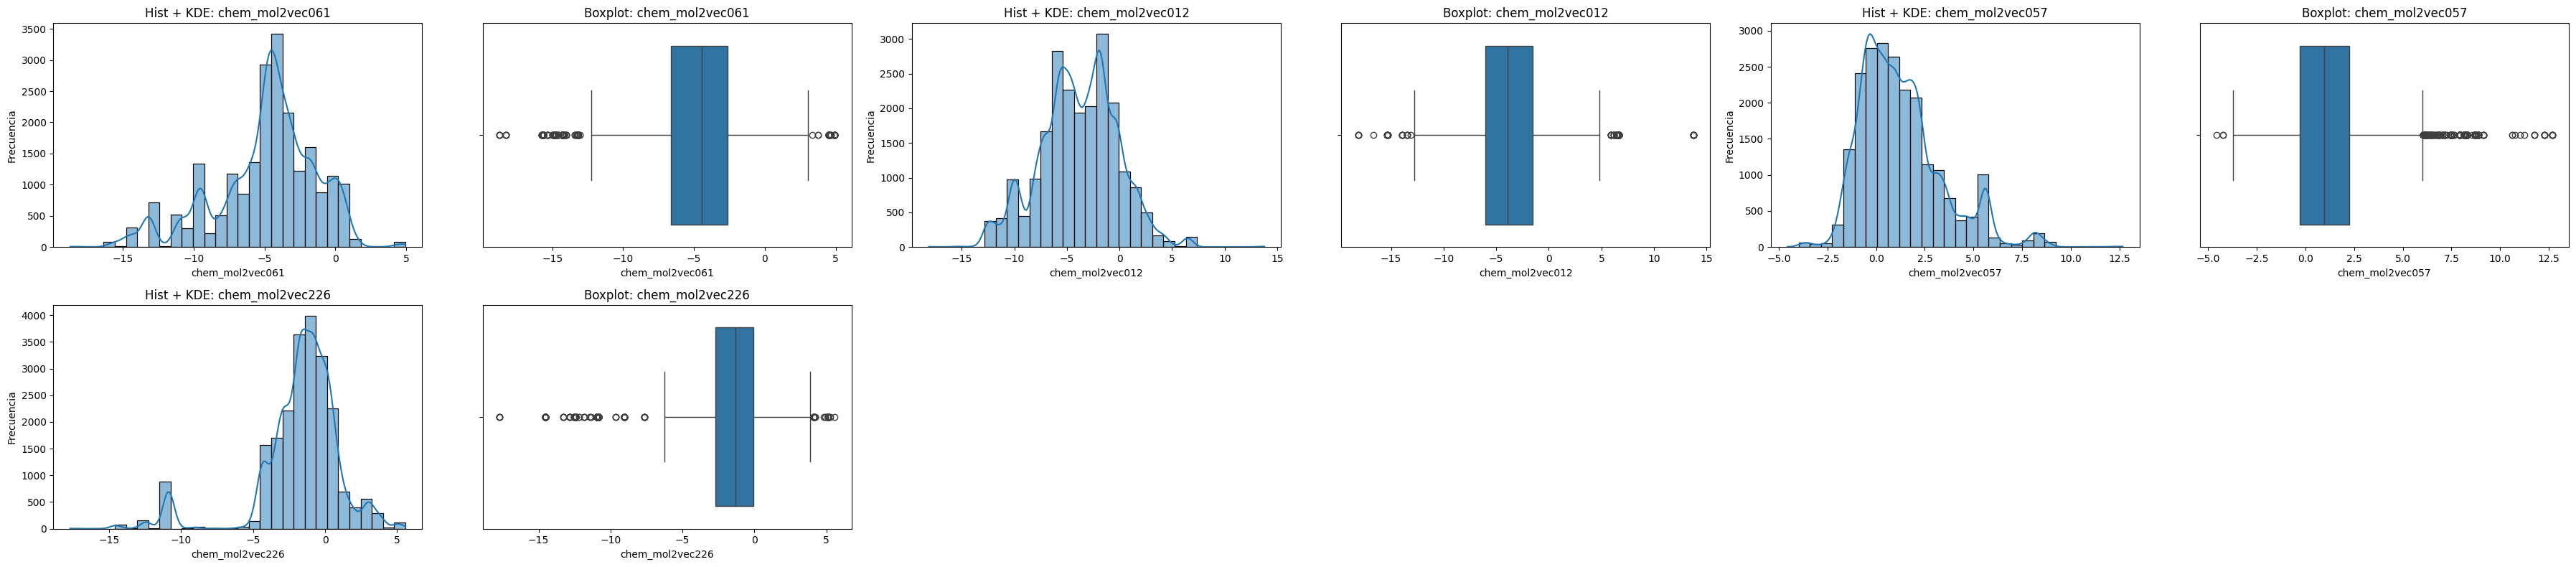

Visualizando grupo: tax con 6 variables


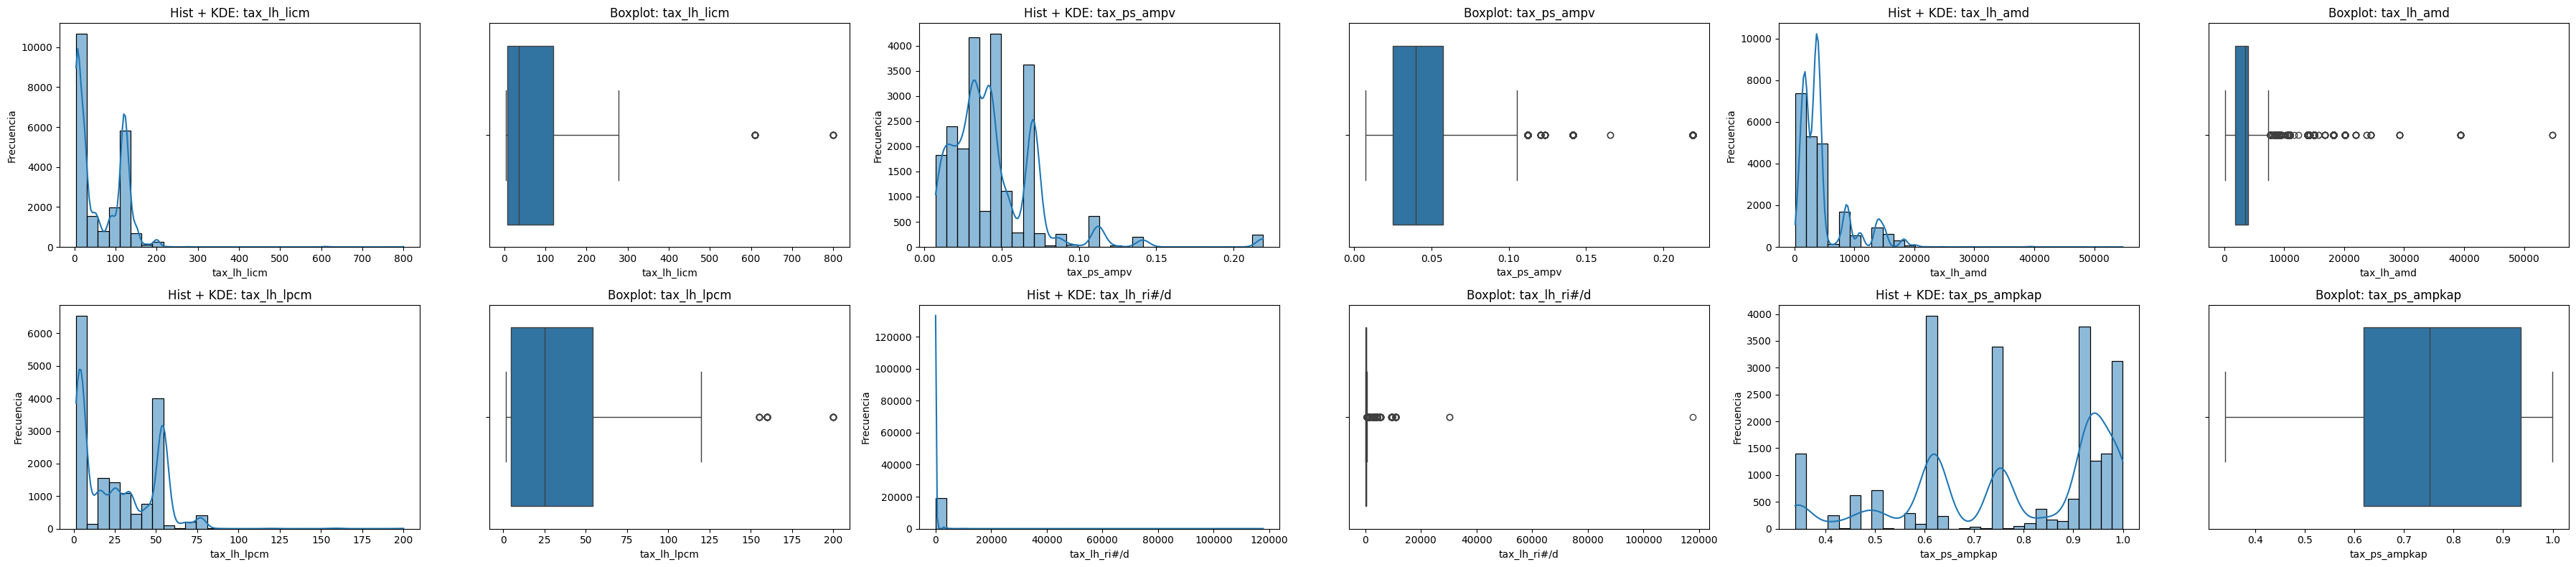

In [42]:
# Visualizaci√≥n
for familia, variables in grupos_variables.items():
    print(f"Visualizando grupo: {familia} con {len(variables)} variables")
    eda.plot_num_univar_grouped(df_modelo, variables, n_cols=3, bins=30)

### Cierre del an√°lisis univariante ‚Äì Variables num√©ricas

Tras analizar individualmente las **39 variables num√©ricas** preseleccionadas, se establecieron las siguientes conclusiones clave para orientar los siguientes pasos del pipeline:

#### Observaciones generales

- La mayor√≠a de variables presentan distribuciones **asim√©tricas o sesgadas a la derecha**, con outliers frecuentes.
- Algunas variables qu√≠micas (`chem_mordred_*`) y taxon√≥micas (`tax_*`) presentan rangos muy amplios o concentraciones extremas que podr√≠an afectar modelos sensibles a la escala.
- Las variables `mol2vec` (embeddings moleculares) mostraron formas razonablemente estables y **no requieren transformaciones**.

#### Decisiones de preprocesado

- **Transformaci√≥n logar√≠tmica o ra√≠z cuadrada** recomendada para ~15 variables con sesgo y outliers relevantes.
- **Escalado opcional** (MinMax o StandardScaler) aplicable a unas 13 variables, especialmente para modelos que lo requieren.
- **Binning o categorizaci√≥n** sugerido solo en 2 casos puntuales con distribuciones multimodales.
- Ninguna variable fue eliminada en esta fase, pero se detectaron **posibles redundancias** dentro de familias (`SRW`, `Xpc`, `MWC`, etc.) a revisar tras el an√°lisis de correlaciones.

#### Siguiente paso

A partir de estas decisiones, se realizar√° un **an√°lisis bivariante frente al target `result_conc1_mean_binary`** para:

- Evaluar el poder predictivo individual de cada variable.
- Detectar relaciones no lineales o patrones relevantes.
- Validar la utilidad real de las variables transformadas.

Este paso permitir√° definir un subconjunto √≥ptimo de variables y transformar solo las necesarias antes de proceder con la modelizaci√≥n.


In [43]:
vars_num_analizar

['media_ph_mean',
 'chem_mordred_Zagreb1',
 'chem_mordred_TSRW10',
 'result_obs_duration_mean',
 'media_temperature_mean',
 'chem_mordred_ATSC0d',
 'chem_mol2vec061',
 'chem_mordred_TMWC10',
 'chem_mordred_Xpc-6d',
 'chem_mordred_mZagreb2',
 'chem_mordred_ATS3Z',
 'chem_mol2vec012',
 'chem_mordred_Xpc-6dv',
 'chem_mordred_SRW05',
 'chem_mordred_Xpc-5dv',
 'chem_mordred_Sm',
 'chem_mordred_SRW02',
 'chem_mordred_SRW07',
 'tax_lh_licm',
 'chem_mordred_ATS0m',
 'chem_mordred_SRW04',
 'chem_mordred_GGI2',
 'chem_mordred_JGI10',
 'tax_ps_ampv',
 'chem_mordred_MWC07',
 'chem_mordred_Xpc-4dv',
 'chem_mordred_SRW06',
 'chem_mordred_MWC08',
 'tax_lh_amd',
 'tax_lh_lpcm',
 'chem_mordred_MWC09',
 'tax_lh_ri#/d',
 'chem_mordred_MWC10',
 'chem_mordred_SRW03',
 'tax_ps_ampkap',
 'chem_mol2vec057',
 'chem_mol2vec226',
 'chem_mordred_MPC8',
 'chem_mordred_NssssC']

In [44]:
# Crear el DataFrame con variables num√©ricas a analizar + target
df_modelo[target] = y_train.copy()

print(df_modelo.shape)  # deber√≠a mostrar (n_filas, 40) -> 39 features + 1 target
df_modelo.columns.tolist()[-1]  # deber√≠a ser 'result_conc1_mean_binary'

(21981, 40)


'result_conc1_mean_binary'

## Variables categoricas
[Indice](#indice)

In [45]:
# Selecci√≥n de variables categ√≥ricas relevantes
vars_cat_analizar = [var for var in vars_analizar_ordenadas if var in vars_categoricas]
print(f"N√∫mero de variables categ√≥ricas a analizar: {len(vars_cat_analizar)}")

N√∫mero de variables categ√≥ricas a analizar: 6


In [46]:
# A√±adirlas a df_modelo desde X_train_validadas
df_modelo = pd.concat([
    df_modelo,
    X_train_validadas[vars_cat_analizar]
], axis=1)

# Verificaci√≥n
print(df_modelo.shape)
df_modelo[vars_cat_analizar].head()

(21981, 46)


tax_gs test_exposure_type test_organism_lifestage result_endpoint  \
0  Cyprinus_carpio                  S                      NR            LC50   
1  Cyprinus_carpio                  S                      NR            LC50   
2  Cyprinus_carpio                  S                      NR            LC50   
3  Cyprinus_carpio                  S                      NR            LC50   
4  Cyprinus_carpio                  S                      NR            LC50   

   tax_family tax_eco_migrate2  
0  Cyprinidae        migration  
1  Cyprinidae        migration  
2  Cyprinidae        migration  
3  Cyprinidae        migration  
4  Cyprinidae        migration

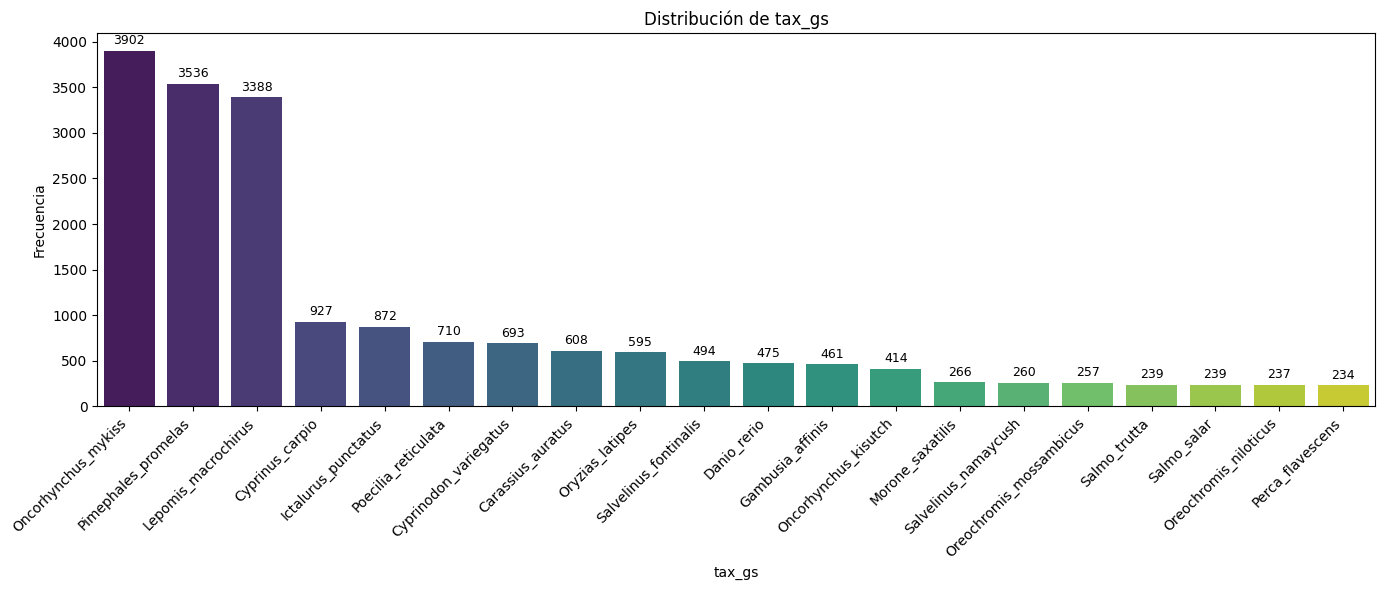

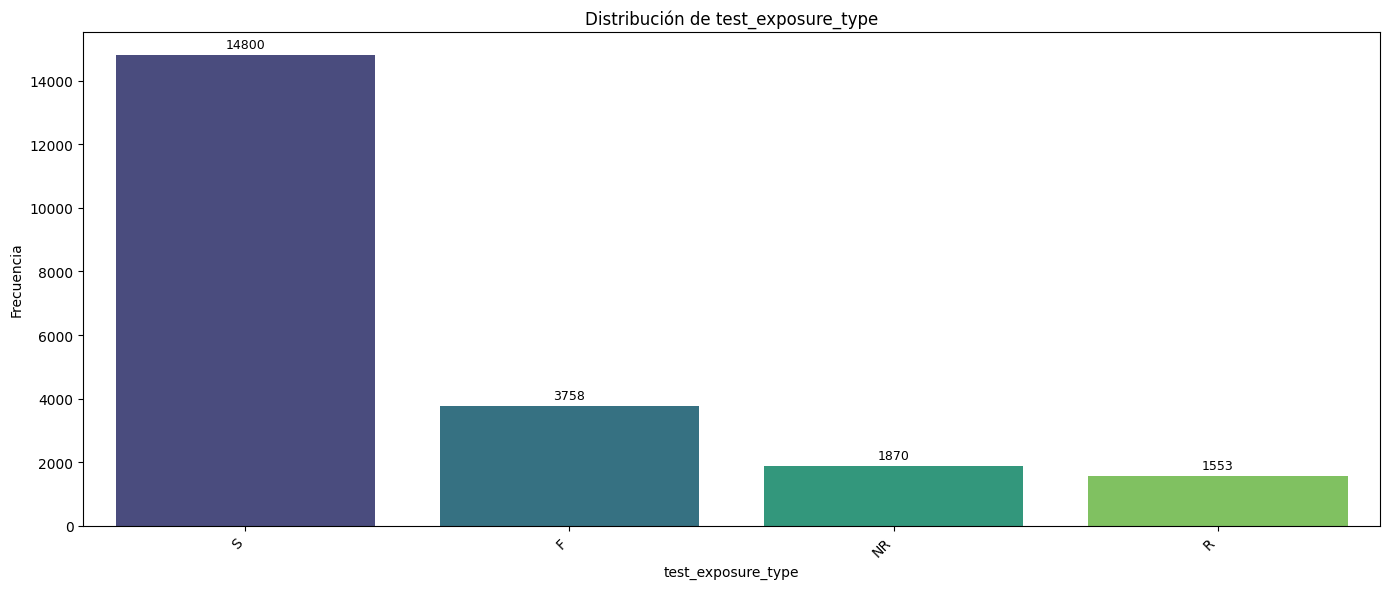

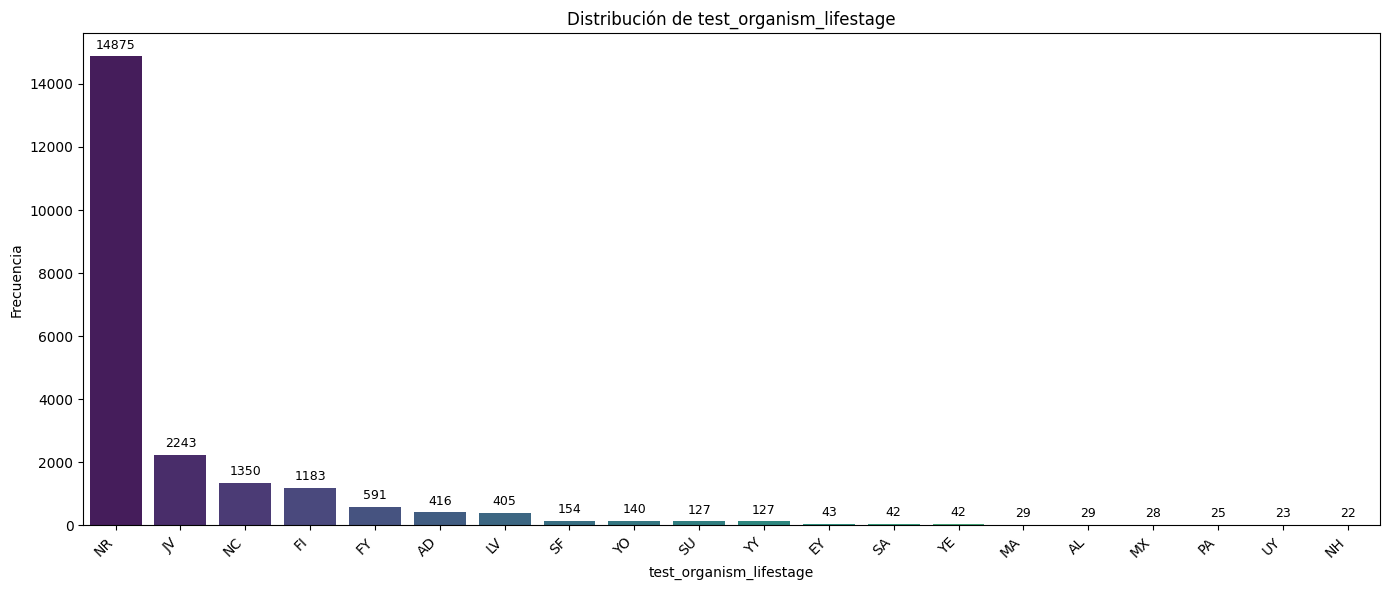

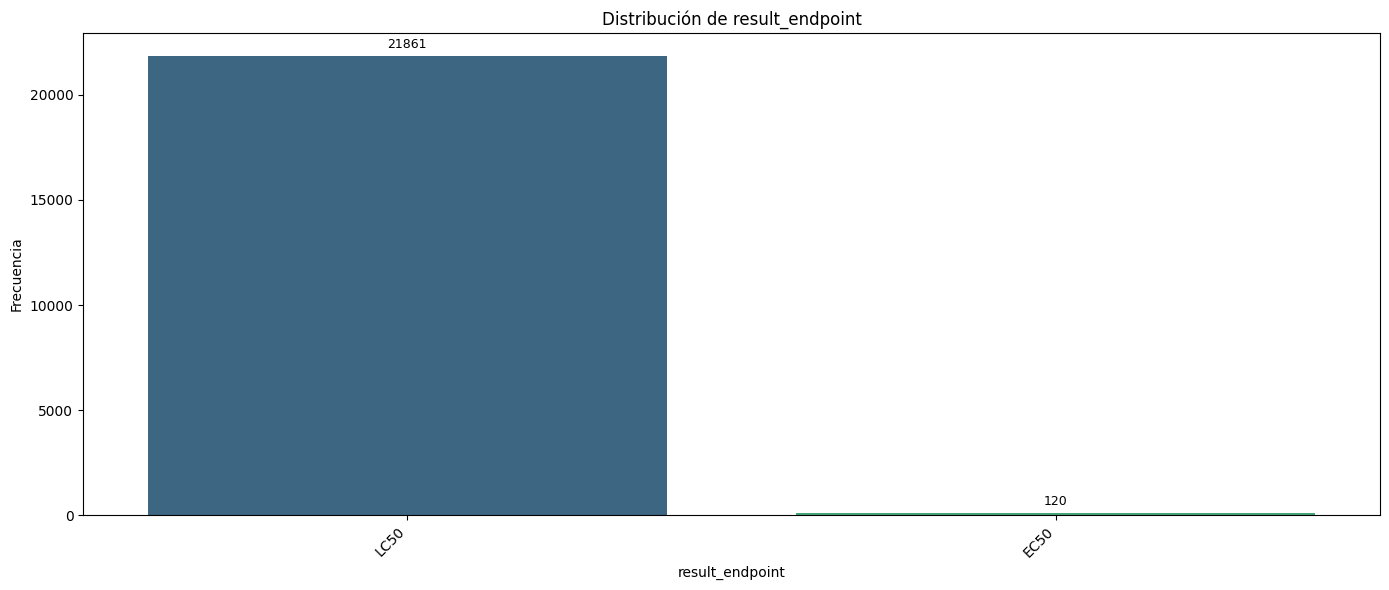

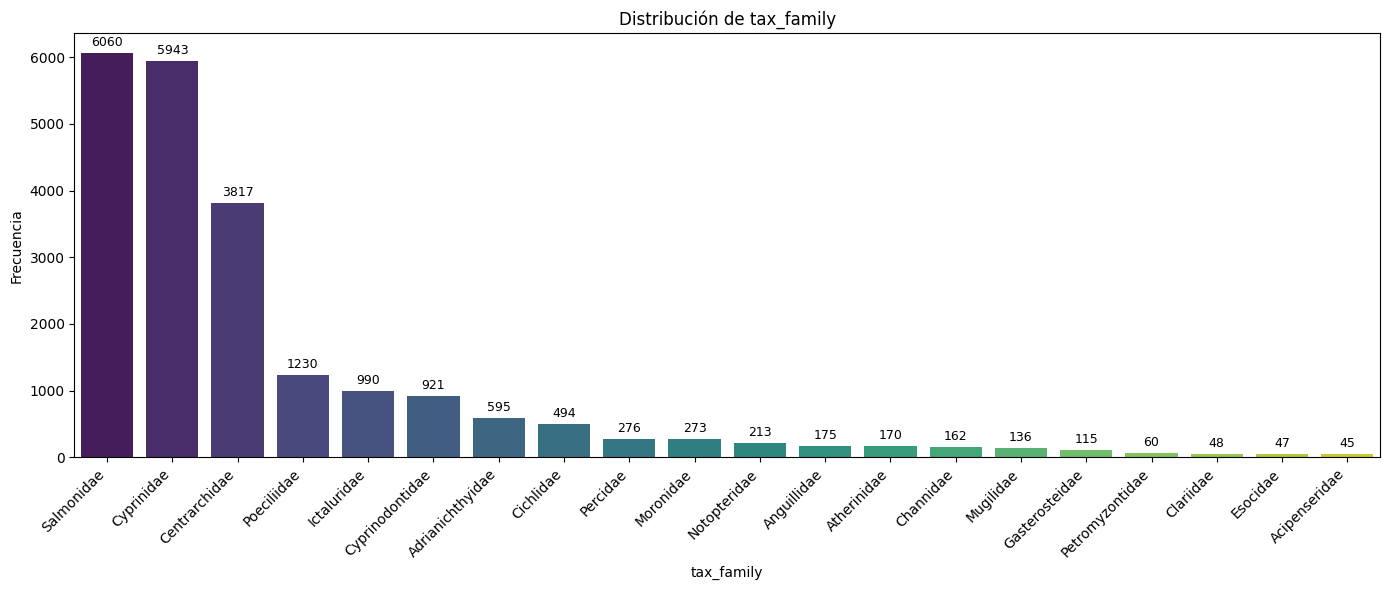

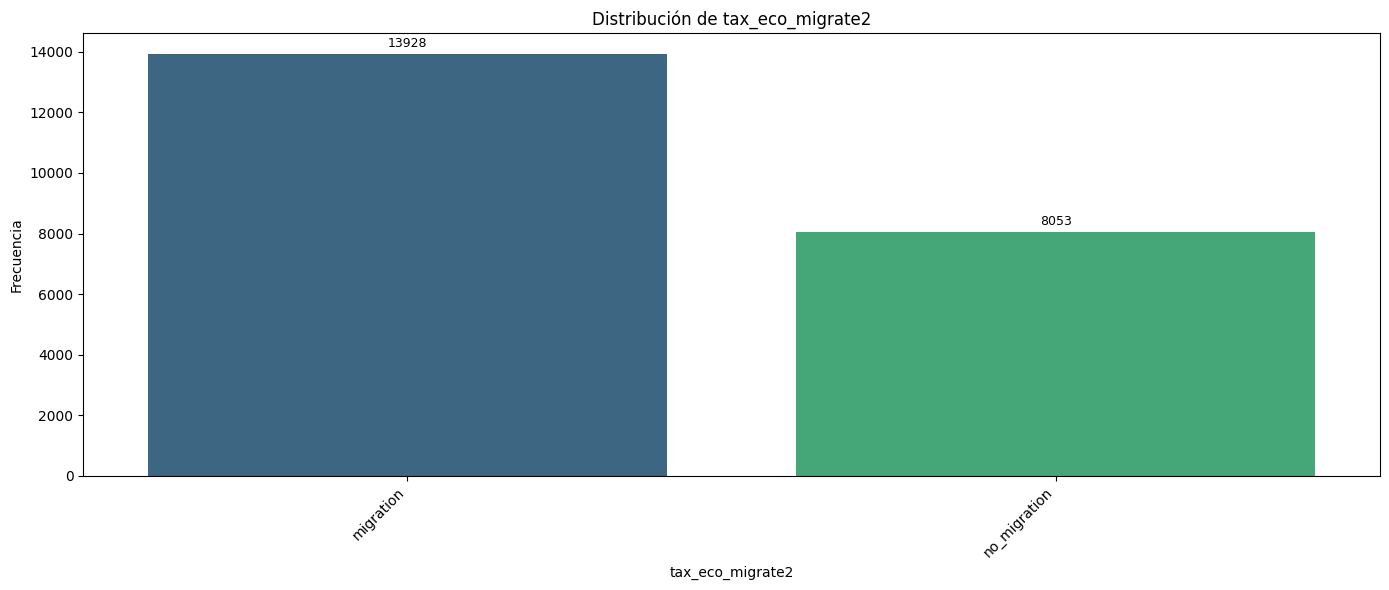

In [47]:
# Visualizaci√≥n univariante
eda.plot_cat_univar(X_train_validadas, vars=vars_cat_analizar, top=20, show_values=True)

### Nota de trazabilidad ‚Äì Exclusi√≥n de `chem_mordred_MWC01`

Durante la integraci√≥n de rankings de importancia (Random Forest y SelectKBest), se identific√≥ que la variable `chem_mordred_MWC01` figuraba entre las top 20 de Random Forest por importancia agregada.

Sin embargo, esta variable **no se encontraba en el conjunto validado `X_train_validadas`**. Tras revisar la plantilla de an√°lisis (`plantilla_analisis_final.csv`), se comprob√≥ que hab√≠a sido previamente **marcada como `duplicada` y eliminada** durante la fase de reducci√≥n estructural de features.

In [48]:
# Detectar la variable que est√° en el ranking pero no se clasific√≥ como num√©rica ni categ√≥rica
set_total = set(vars_analizar_ordenadas)
set_analizadas = set(vars_num_analizar + vars_cat_analizar)
faltante = set_total - set_analizadas

print(f"Variable no clasificada: {faltante}")

Variable no clasificada: {'chem_mordred_MWC01'}


In [49]:
plantilla_analisis.query("nombre_variable == 'chem_mordred_MWC01'")

nombre_variable      tipo_sugerido segmento expectativas conclusion  \
1066  chem_mordred_MWC01  Num√©rica Discreta  qu√≠mico    duplicada   eliminar   

     grupo_expectativa  importancia  
1066         duplicada          NaN

# Analisis Bivariante
[Indice](#indice)

## Variables numericas vs. target

Tras el an√°lisis univariante, se han clasificado las 39 variables num√©ricas en cinco familias funcionales en funci√≥n de su naturaleza y origen:

| Familia         | Descripci√≥n                                                                 |
|-----------------|------------------------------------------------------------------------------|
| `chem_mordred`  | Descriptores moleculares cl√°sicos calculados con Mordred                   |
| `chem_mol2vec`  | Embeddings vectoriales a partir de representaciones SMILES (`mol2vec`)     |
| `tax`           | Variables taxon√≥micas (distancias filogen√©ticas, diversidad, conservaci√≥n) |
| `media`         | Condiciones experimentales  (pH, temperatura)                         |
| `result`        | Duraci√≥n de los ensayos de toxicidad                                       |

Esta clasificaci√≥n nos permite organizar el an√°lisis bivariante de forma m√°s eficiente, y detectar patrones diferenciados seg√∫n el tipo de variable:

- Los **descriptores `chem_mordred`** suelen requerir transformaci√≥n logar√≠tmica o escalado, pero pueden ser informativos si se alinean con mecanismos moleculares de toxicidad.
- Las variables `mol2vec` ya est√°n estandarizadas y pueden evaluarse sin transformaci√≥n.
- Las **variables taxon√≥micas** reflejan propiedades del organismo expuesto, como su filogenia o tolerancia, y podr√≠an ser muy predictivas.
- Las variables de tipo `media` y `result` son contextuales del experimento y pueden actuar como modificadores o confundidores.


### Objetivo de este an√°lisis

Evaluar, para cada variable, su **relaci√≥n con el target binario** `result_conc1_mean_binary`, mediante:

- Visualizaci√≥n de su distribuci√≥n seg√∫n clase del target (usando violinplots o boxplots).
- Comparaci√≥n de medias/medianas por clase.
- C√°lculo de m√©tricas estad√≠sticas relevantes (por ejemplo: ANOVA, U de Mann-Whitney, AUC, etc.).

Esto nos permitir√°:

- Detectar variables con potencial predictivo individual.
- Verificar si las transformaciones realizadas mejoran la separabilidad.
- Descartar variables que no aporten informaci√≥n relevante.


>Colores:
    üî¥ cumple AUC y p-valor
    üü° solo p-valor significativo
    üîµ solo AUC alto
    ‚ö´ no destaca


 Analizando grupo: media


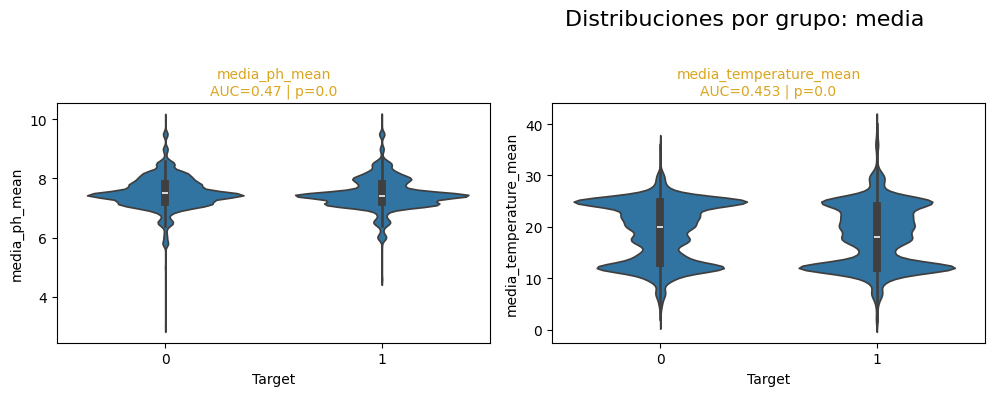


 Analizando grupo: mordred


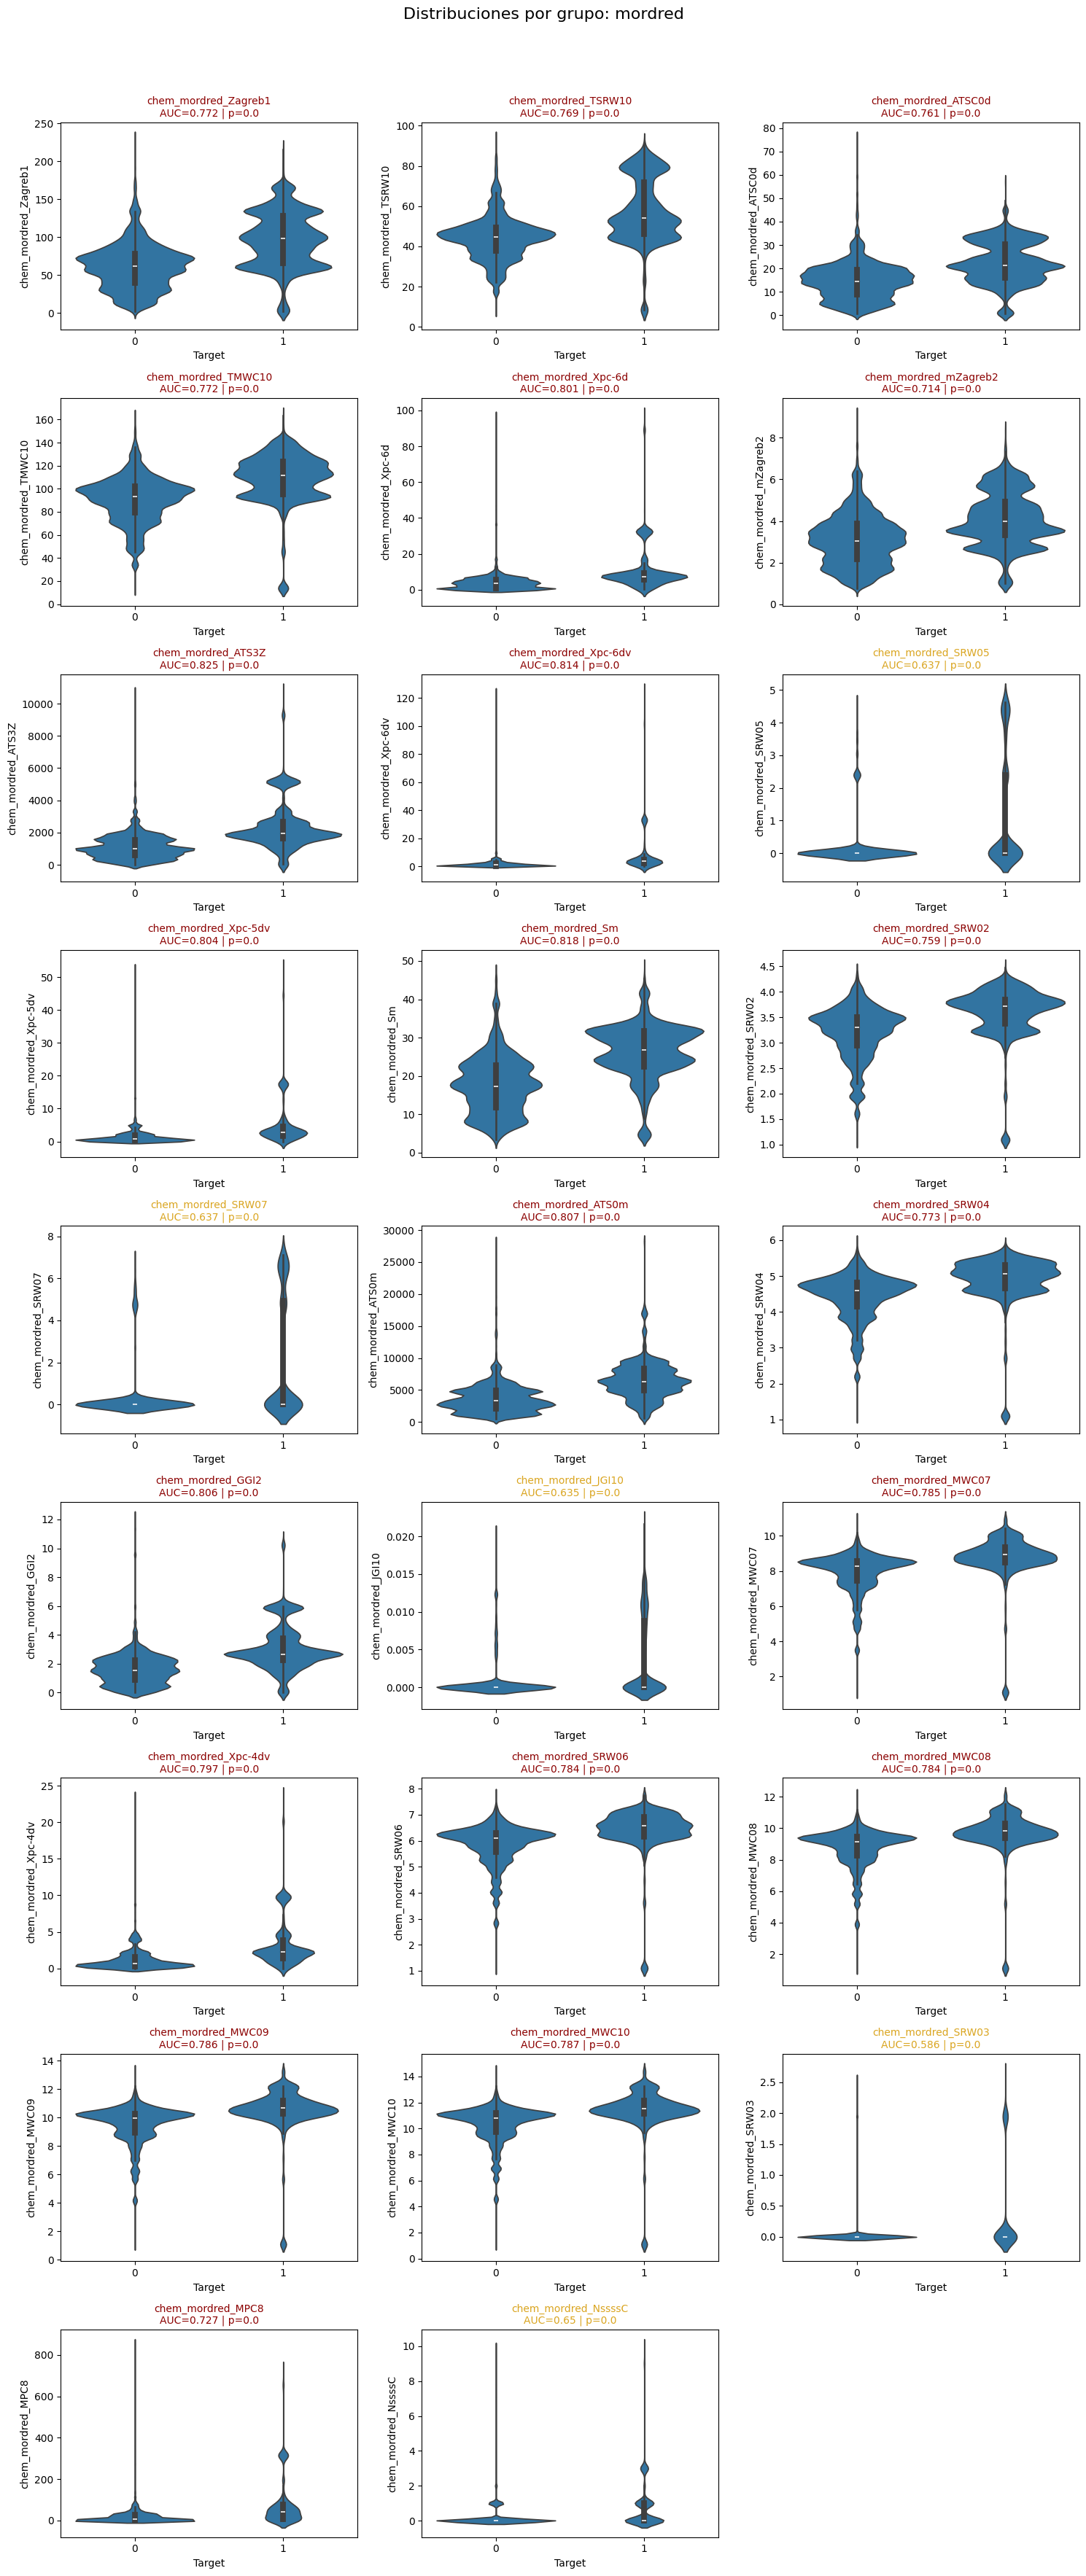


 Analizando grupo: result


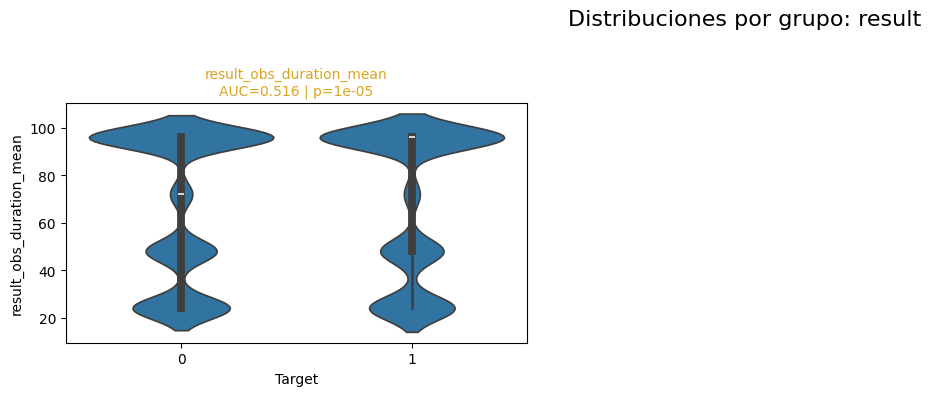


 Analizando grupo: mol2vec


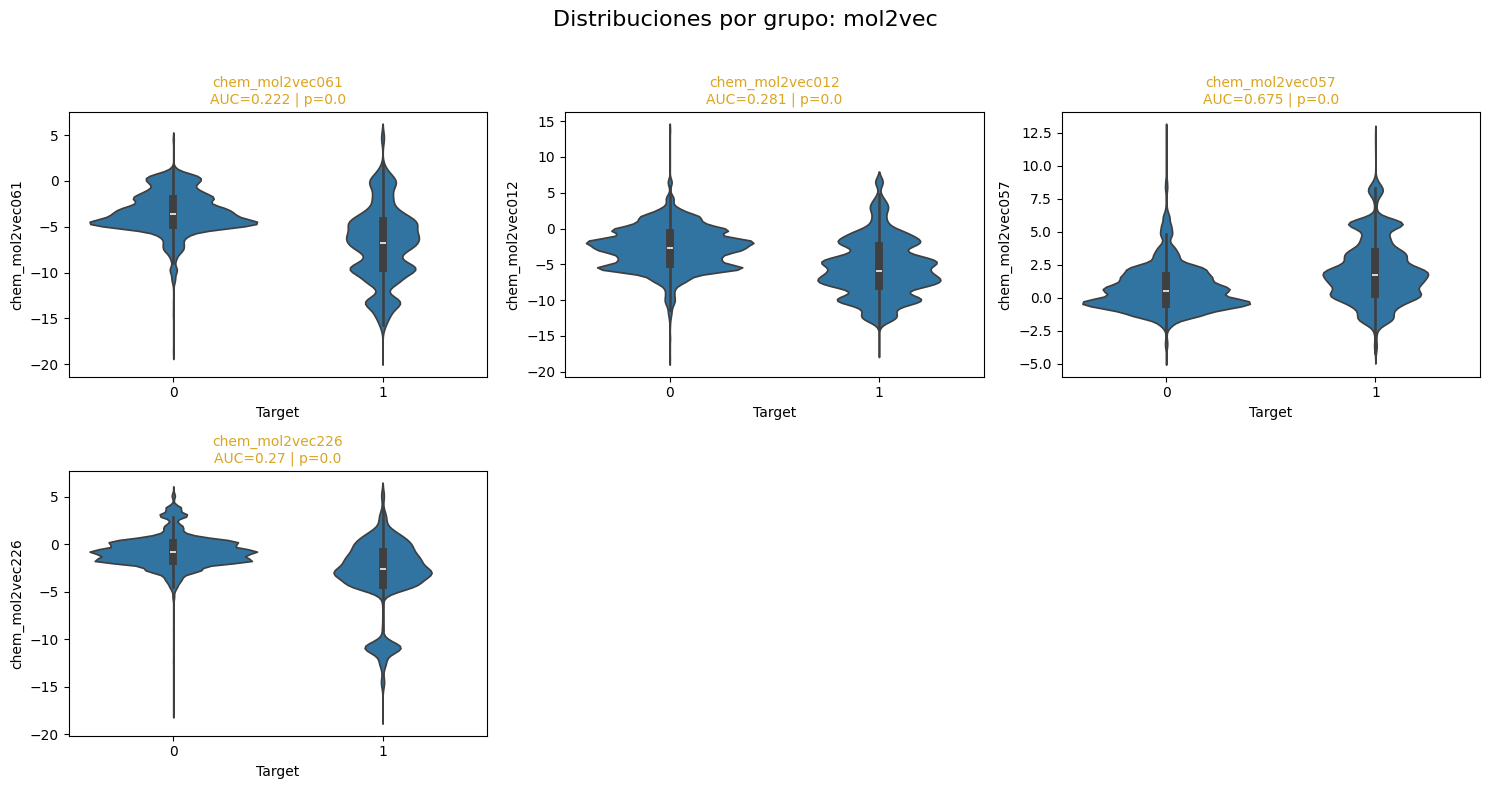


 Analizando grupo: tax


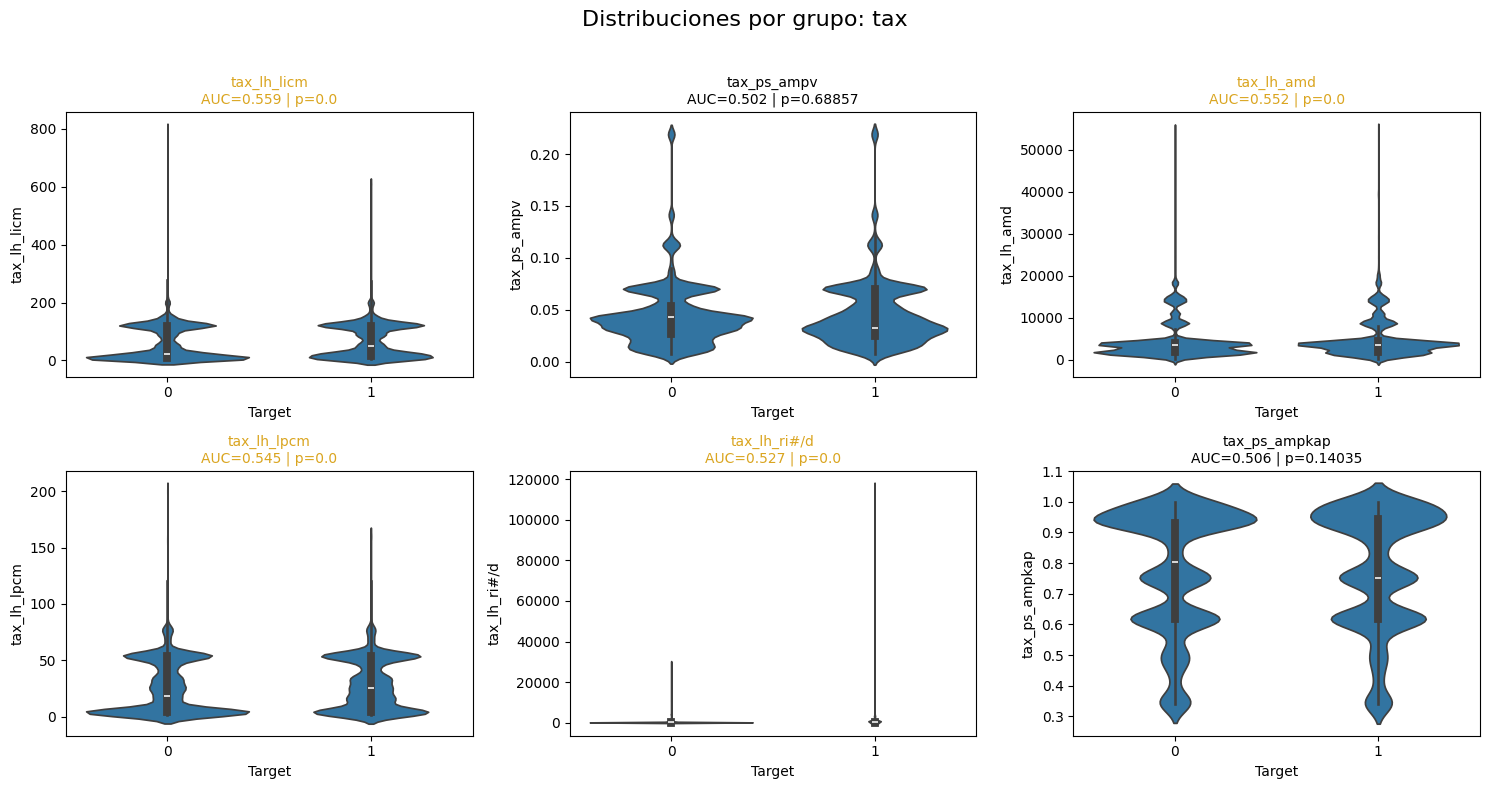

In [50]:
# Inicializar un DataFrame vac√≠o para acumular resultados
resultados_bivariantes = pd.DataFrame()

# Iterar por cada grupo (familia)
for familia, variables in grupos_variables.items():
    print(f"\n Analizando grupo: {familia}")
    
    # 1. An√°lisis bivariante con m√©tricas
    resultados = eda.analisis_bivariante_grupo(
        df=df_modelo,
        variables=variables,
        target="result_conc1_mean_binary",
        group_name=familia, 
        plot=False  # desactiva los plots individuales
    )
    
    #2. Acumular resultados
    resultados_bivariantes = pd.concat([resultados_bivariantes, resultados], ignore_index=True)
    
    # 3. Mostrar violinplots agrupados con AUC y p-valor
    eda.plot_violin_grouped(
        df=df_modelo,
        variables=variables,
        target="result_conc1_mean_binary",
        group_name=familia,
        df_resultados=resultados,
        auc_threshold=0.7,            
        pval_threshold=0.05
)

### Conclusiones preliminares del an√°lisis bivariante

An√°lisis realizado sobre 39 variables frente al target binario (`result_conc1_mean_binary`), agrupadas por funcionalidad. Evaluaci√≥n basada en:  
- AUC (Area Under Curve)
- p-valor de test estad√≠stico
- Forma de la distribuci√≥n (violin plots)


#### 1. Grupo `media` ‚Äì Condiciones experimentales

Variables:  
- `media_ph_mean`, `media_temperature_mean`

Ambas variables muestran p-valor significativo pero AUC < 0.5, con distribuciones casi id√©nticas entre clases.

**Conclusi√≥n**: No aportan se√±al predictiva ‚Üí **Descartar**

#### 2. Grupo `mordred` ‚Äì Descriptores moleculares

Es el grupo m√°s informativo. Se identifican m√∫ltiples variables con AUC > 0.75 y buena separaci√≥n visual:

**Variables destacadas (para conservar):**  
- `Zagreb1`, `TSRW10`, `ATSC0d`, `TMWC10`, `Xpc-6d`, `mZagreb2`, `ATS3Z` ,`Xpc-6dv`, `Xpc-5dv`, `Sm`,  
  `SRW02`, `ATS0m`,  `SRW04`, `GGI2`, `MWC07`, `Xpc-4dv` , `SRW06`, `MWC08`, `MWC09`, `MWC10`, `MPC8`
        

**Variables con AUC bajo o nula separaci√≥n (para descartar):**  
- `SRW03`, `SRW05`, `SRW07`, `JGI10`, `NssssC`

**Conclusi√≥n**: El grupo aporta el grueso de las features candidatas.  
Se recomienda revisar colinealidad entre variables similares (ej. MWC*, Xpc*).

#### 3. Grupo `result` ‚Äì Duraci√≥n de observaci√≥n

Variable:  
- `result_obs_duration_mean`

AUC ‚âà 0.51, p-valor significativo pero sin diferencia visual clara.

**Conclusi√≥n**: Variable irrelevante ‚Üí **Descartar**

#### 4. Grupo `mol2vec` ‚Äì Embeddings moleculares

Variables:  
- `mol2vec057`, `mol2vec012`, `mol2vec061`, `mol2vec226`

Solo `mol2vec057` muestra una separaci√≥n moderada (AUC ‚âà 0.675).  
El resto tienen AUC < 0.3, a pesar del p-valor.

**Conclusi√≥n**:  
- Conservar: `mol2vec057`  
- Descartar: `mol2vec012`, `mol2vec061`, `mol2vec226`

### 5. Grupo `tax` ‚Äì Variables taxon√≥micas

Variables:  
- `tax_lh_licm`, `tax_lh_amd`, `tax_lh_lpcm`, `tax_lh_ri#/d`, `tax_ps_ampv`, `tax_ps_ampkap`

Todas con AUC entre 0.50 y 0.56, sin separaci√≥n √∫til.

**Conclusi√≥n**: No aportan valor predictivo ‚Üí **Descartar**

In [51]:
# Variables candidatas a conservar 
# Variables candidatas a conservar (corregidas)
features_preseleccionadas = [
    "chem_mordred_Zagreb1",
    "chem_mordred_TSRW10",
    "chem_mordred_ATSC0d",
    "chem_mordred_TMWC10",
    "chem_mordred_mZagreb2",
    "chem_mordred_ATS3Z",        # corregido
    "chem_mordred_Xpc-6dv",
    "chem_mordred_Xpc-5dv",
    "chem_mordred_Xpc-6d",
    "chem_mordred_Sm",
    "chem_mordred_SRW02",
    "chem_mordred_SRW04",
    "chem_mordred_SRW06",
    "chem_mordred_MWC07",
    "chem_mordred_MWC08",
    "chem_mordred_MWC09",
    "chem_mordred_MWC10",
    "chem_mordred_ATS0m",
    "chem_mordred_GGI2",
    "chem_mordred_MPC8",        # corregido
    "chem_mol2vec057"
]


### Subconjunto de variables contextuales no predictivas

Aunque muchas variables taxon√≥micas (`tax_*`) y experimentales (`media_*`, `result_*`) no mostraron una relaci√≥n bivariante significativa con el target, podr√≠an aportar valor indirecto en modelos m√°s complejos. Por ejemplo:

- Introduciendo **contexto ambiental o biol√≥gico**.
- Capturando **interacciones sutiles** con descriptores moleculares.
- Mejorando la **capacidad de generalizaci√≥n** si el modelo se entrena con muestras diversas.

#### ¬øPor qu√© conservar algunas variables contextuales?

- Estas variables no son predictoras fuertes por s√≠ solas (AUC bajo),  
  pero pueden **ayudar al modelo a adaptarse a condiciones espec√≠ficas** (especie, temperatura, pH).
- Son especialmente √∫tiles en tareas donde se acepta cierto grado de **ajuste al contexto** m√°s que generalizaci√≥n pura.
- Su valor se puede evaluar emp√≠ricamente en una segunda etapa con validaci√≥n cruzada.

In [52]:
features_contextuales = [
    "media_ph_mean",               # condiciones ambientales
    "media_temperature_mean",
    "tax_lh_licm",                 # medidas taxon√≥micas/filogen√©ticas
    "tax_lh_amd",
    "tax_lh_lpcm",
    "tax_lh_ri#/d"
]

### Colinealidad
[Indice](#indice)

Una vez completado el an√°lisis univariante y bivariante, se procede a revisar la colinealidad entre las variables num√©ricas seleccionadas. La colinealidad (o multicolinealidad) se refiere a la presencia de fuertes correlaciones entre pares de variables, lo que puede provocar inestabilidad en los modelos de machine learning, especialmente aquellos basados en coeficientes (e.g., regresi√≥n log√≠stica).

En este an√°lisis:

- Se calcula la matriz de correlaci√≥n de Pearson entre todas las variables num√©ricas del dataset modelable (`df_modelo`).
- Se identifican pares con correlaci√≥n absoluta mayor o igual a `0.9`.
- Para cada par correlacionado, se sugiere eliminar la variable menos √∫til seg√∫n el criterio de mayor `AUC univariado`, obtenido del an√°lisis bivariante.

Este procedimiento permite reducir la redundancia informativa y prevenir sobreajuste, conservando aquellas variables con mayor poder predictivo individual.

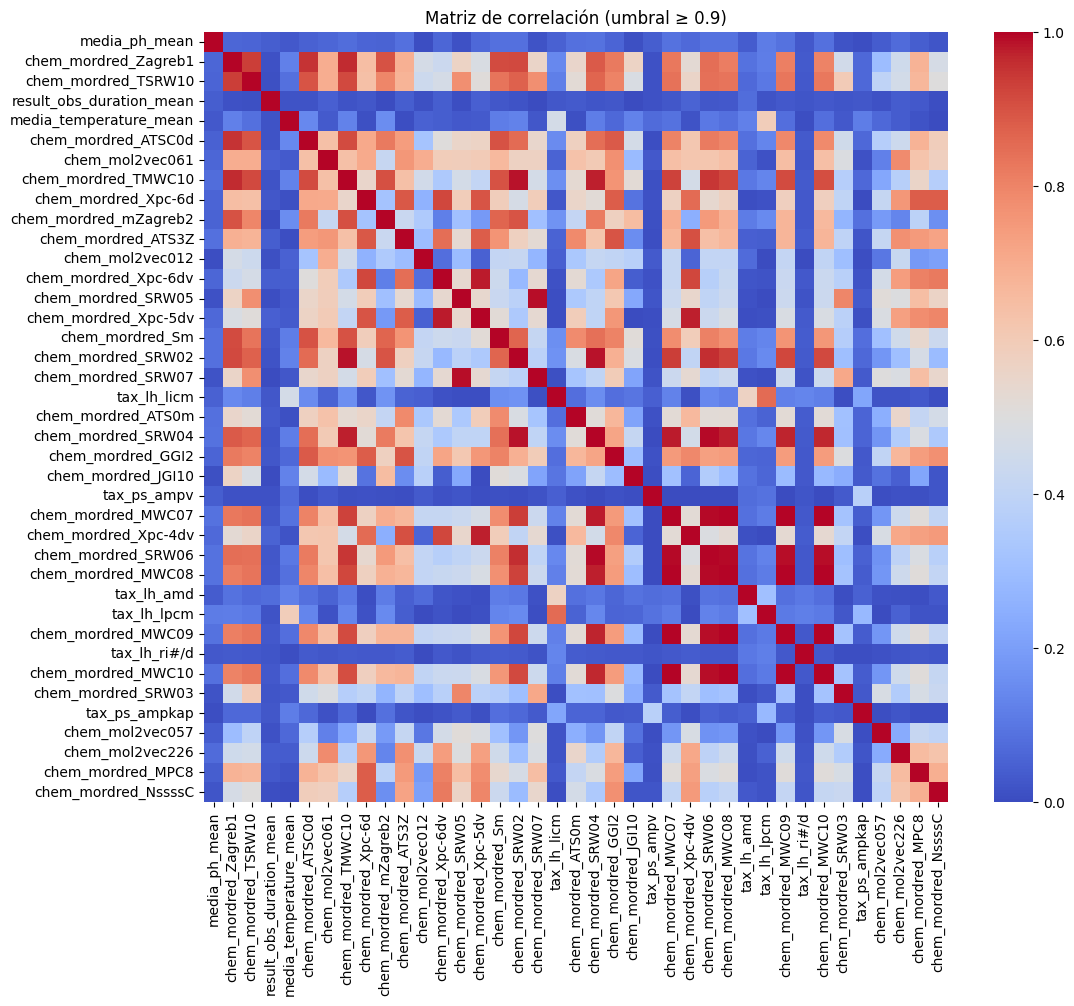

Variable 1             Variable 2  Correlaci√≥n
42    chem_mordred_MWC09     chem_mordred_MWC10     0.999765
40    chem_mordred_MWC08     chem_mordred_MWC09     0.999753
34    chem_mordred_MWC07     chem_mordred_MWC08     0.999597
41    chem_mordred_MWC08     chem_mordred_MWC10     0.999518
35    chem_mordred_MWC07     chem_mordred_MWC09     0.999289
36    chem_mordred_MWC07     chem_mordred_MWC10     0.998443
33    chem_mordred_MWC07     chem_mordred_SRW06     0.994586
37    chem_mordred_SRW06     chem_mordred_MWC08     0.993379
29    chem_mordred_SRW04     chem_mordred_SRW06     0.992328
38    chem_mordred_SRW06     chem_mordred_MWC09     0.991040
39    chem_mordred_SRW06     chem_mordred_MWC10     0.989778
20    chem_mordred_SRW05     chem_mordred_SRW07     0.988867
9    chem_mordred_TMWC10     chem_mordred_SRW02     0.986253
22    chem_mordred_SRW02     chem_mordred_SRW04     0.985305
18  chem_mordred_Xpc-6dv   chem_mordred_Xpc-5dv     0.980034
28    chem_mordred_SRW04     chem_mordred_MWC07     0.978656
30    chem_mordred_SRW04     chem_mordred_MWC08     0.974767
10   chem_mordred_TMWC10     chem_mordred_SRW04     0.973513
21  chem_mordred_Xpc-5dv   chem_mordred_Xpc-4dv     0.972801
31    chem_mordred_SRW04     chem_mordred_MWC09     0.970699
32    chem_mordred_SRW04     chem_mordred_MWC10     0.967576
2   chem_mordred_Zagreb1    chem_mordred_TMWC10     0.962995
24    chem_mordred_SRW02     chem_mordred_SRW06     0.957353
1   chem_mordred_Zagreb1    chem_mordred_ATSC0d     0.951804
12   chem_mordred_TMWC10     chem_mordred_SRW06     0.946460
0   chem_mordred_Zagreb1    chem_mordred_TSRW10     0.935959
23    chem_mordred_SRW02     chem_mordred_MWC07     0.934575
25    chem_mordred_SRW02     chem_mordred_MWC08     0.926627
11   chem_mordred_TMWC10     chem_mordred_MWC07     0.925801
26    chem_mordred_SRW02     chem_mordred_MWC09     0.920869
19  chem_mordred_Xpc-6dv   chem_mordred_Xpc-4dv     0.919566
16   chem_mordred_Xpc-6d   chem_mordred_Xpc-6dv     0.918600
13   chem_mordred_TMWC10     chem_mordred_MWC08     0.918327
5    chem_mordred_TSRW10    chem_mordred_TMWC10     0.917005
4   chem_mordred_Zagreb1     chem_mordred_SRW02     0.914895
27    chem_mordred_SRW02     chem_mordred_MWC10     0.914858
14   chem_mordred_TMWC10     chem_mordred_MWC09     0.912556
6    chem_mordred_ATSC0d    chem_mordred_TMWC10     0.911909
3   chem_mordred_Zagreb1        chem_mordred_Sm     0.911480
15   chem_mordred_TMWC10     chem_mordred_MWC10     0.906939
17    chem_mordred_ATS3Z   chem_mordred_Xpc-4dv     0.906014
7    chem_mordred_TMWC10  chem_mordred_mZagreb2     0.905345
8    chem_mordred_TMWC10        chem_mordred_Sm     0.900600

In [53]:
# Ejecutar an√°lisis de colinealidad
df_pares_colineales = eda.analizar_colinealidad(
    df=df_modelo,
    variables=vars_num_analizar,
    umbral=0.9,
    mostrar_heatmap=True
)

# Mostrar resultados si hay
if df_pares_colineales.empty:
    print("No se encontraron pares colineales con ese umbral.")
else:
    display(df_pares_colineales)

#### Alta colinealidad en el grupo `chem_mordred`

Como se observa en la matriz de correlaci√≥n, la gran mayor√≠a de las relaciones altamente colineales se concentran en el grupo de variables `chem_mordred`. Esto es esperable, ya que estos descriptores moleculares computados por el paquete Mordred incluyen medidas derivadas, transformaciones y combinaciones que suelen solaparse en la informaci√≥n que capturan.

Por esta raz√≥n, se aplica un proceso selectivo para conservar solo una variable representativa por cl√∫ster de colinealidad. El criterio de elecci√≥n es el `AUC univariado`, favoreciendo la variable con mayor capacidad predictiva frente al target (`result_conc1_mean_binary`).

#### Sugerencia de variables a eliminar por colinealidad

A continuaci√≥n se muestra una tabla resumen con las parejas altamente correlacionadas (|r| ‚â• 0.9), el valor de AUC univariado de cada una y la variable sugerida para eliminar. Esta sugerencia se basa exclusivamente en el criterio de retener aquella con mayor AUC univariado.

Esta decisi√≥n puede ser refinada manualmente si existen razones de interpretabilidad, dominio del negocio o validaci√≥n experimental.

In [54]:
# Generar sugerencias para limpieza de colinealidad
df_log_colinealidad, variables_a_eliminar = eda.sugerir_variables_a_eliminar_opt(
    df_pares_correlados=df_pares_colineales,
    df_resultados=resultados_bivariantes,
    criterio="AUC_univariado"
)

# Visualizar log explicativo
display(df_log_colinealidad)

# Lista final √∫nica
print("Variables a eliminar:", variables_a_eliminar)

Variable_1             Variable_2  Correlaci√≥n  \
0     chem_mordred_MWC09     chem_mordred_MWC10     0.999765   
1     chem_mordred_MWC08     chem_mordred_MWC09     0.999753   
2     chem_mordred_MWC07     chem_mordred_MWC09     0.999289   
3     chem_mordred_MWC07     chem_mordred_SRW06     0.994586   
4     chem_mordred_SRW04     chem_mordred_SRW06     0.992328   
5     chem_mordred_SRW05     chem_mordred_SRW07     0.988867   
6    chem_mordred_TMWC10     chem_mordred_SRW02     0.986253   
7   chem_mordred_Xpc-6dv   chem_mordred_Xpc-5dv     0.980034   
8    chem_mordred_TMWC10     chem_mordred_SRW04     0.973513   
9   chem_mordred_Xpc-5dv   chem_mordred_Xpc-4dv     0.972801   
10  chem_mordred_Zagreb1    chem_mordred_ATSC0d     0.951804   
11  chem_mordred_Zagreb1    chem_mordred_TSRW10     0.935959   
12   chem_mordred_Xpc-6d   chem_mordred_Xpc-6dv     0.918600   
13  chem_mordred_Zagreb1        chem_mordred_Sm     0.911480   
14   chem_mordred_TMWC10  chem_mordred_mZagreb2     0.905345   

    AUC_univariado_chem_mordred_MWC09  AUC_univariado_chem_mordred_MWC10  \
0                               0.786                              0.787   
1                               0.786                                NaN   
2                               0.786                                NaN   
3                                 NaN                                NaN   
4                                 NaN                                NaN   
5                                 NaN                                NaN   
6                                 NaN                                NaN   
7                                 NaN                                NaN   
8                                 NaN                                NaN   
9                                 NaN                                NaN   
10                                NaN                                NaN   
11                                NaN                                NaN   
12                                NaN                                NaN   
13                                NaN                                NaN   
14                                NaN                                NaN   

               A_eliminar  AUC_univariado_chem_mordred_MWC08  \
0      chem_mordred_MWC09                                NaN   
1      chem_mordred_MWC08                              0.784   
2      chem_mordred_MWC07                                NaN   
3      chem_mordred_SRW06                                NaN   
4      chem_mordred_SRW04                                NaN   
5      chem_mordred_SRW07                                NaN   
6      chem_mordred_SRW02                                NaN   
7    chem_mordred_Xpc-5dv                                NaN   
8     chem_mordred_TMWC10                                NaN   
9    chem_mordred_Xpc-4dv                                NaN   
10    chem_mordred_ATSC0d                                NaN   
11    chem_mordred_TSRW10                                NaN   
12    chem_mordred_Xpc-6d                                NaN   
13   chem_mordred_Zagreb1                                NaN   
14  chem_mordred_mZagreb2                                NaN   

    AUC_univariado_chem_mordred_MWC07  AUC_univariado_chem_mordred_SRW06  \
0                                 NaN                                NaN   
1                                 NaN                                NaN   
2                               0.785                                NaN   
3                               0.785                              0.784   
4                                 NaN                              0.784   
5                                 NaN                                NaN   
6                                 NaN                                NaN   
7                                 NaN                                NaN   
8                                 NaN                         

Variables a eliminar: ['chem_mordred_SRW07', 'chem_mordred_SRW02', 'chem_mordred_Xpc-6d', 'chem_mordred_Zagreb1', 'chem_mordred_Xpc-5dv', 'chem_mordred_TSRW10', 'chem_mordred_SRW04', 'chem_mordred_mZagreb2', 'chem_mordred_ATSC0d', 'chem_mordred_MWC07', 'chem_mordred_MWC08', 'chem_mordred_Xpc-4dv', 'chem_mordred_SRW06', 'chem_mordred_TMWC10', 'chem_mordred_MWC09']


## Variables categoricas vs Target

In [55]:
# Verificaci√≥n de variables categ√≥ricas en X_train_validadas

# Detectar autom√°ticamente columnas categ√≥ricas (tipo object o category)
vars_categoricas_detectadas = X_train_validadas.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Mostrar resultado
print("Variables categ√≥ricas detectadas:")
print(vars_categoricas_detectadas)

Variables categ√≥ricas detectadas:
['test_cas', 'test_exposure_type', 'test_control_type', 'test_media_type', 'test_application_freq_unit', 'test_organism_lifestage', 'result_endpoint', 'tax_class', 'tax_order', 'tax_family', 'tax_gs', 'tax_eco_climate', 'tax_eco_ecozone', 'tax_eco_food', 'tax_eco_migrate5', 'tax_eco_migrate2', 'chem_sf', 'chem_pcp_fp', 'chem_MACCS_fp', 'chem_Morgan_fp', 'chem_ToxPrint_fp']


In [56]:
vars_cat_analizar = [var for var in vars_categoricas_detectadas if var in vars_analizar_ordenadas]

print("\n Variables categ√≥ricas seleccionadas para an√°lisis:")
print(vars_cat_analizar)


 Variables categ√≥ricas seleccionadas para an√°lisis:
['test_exposure_type', 'test_organism_lifestage', 'result_endpoint', 'tax_family', 'tax_gs', 'tax_eco_migrate2']


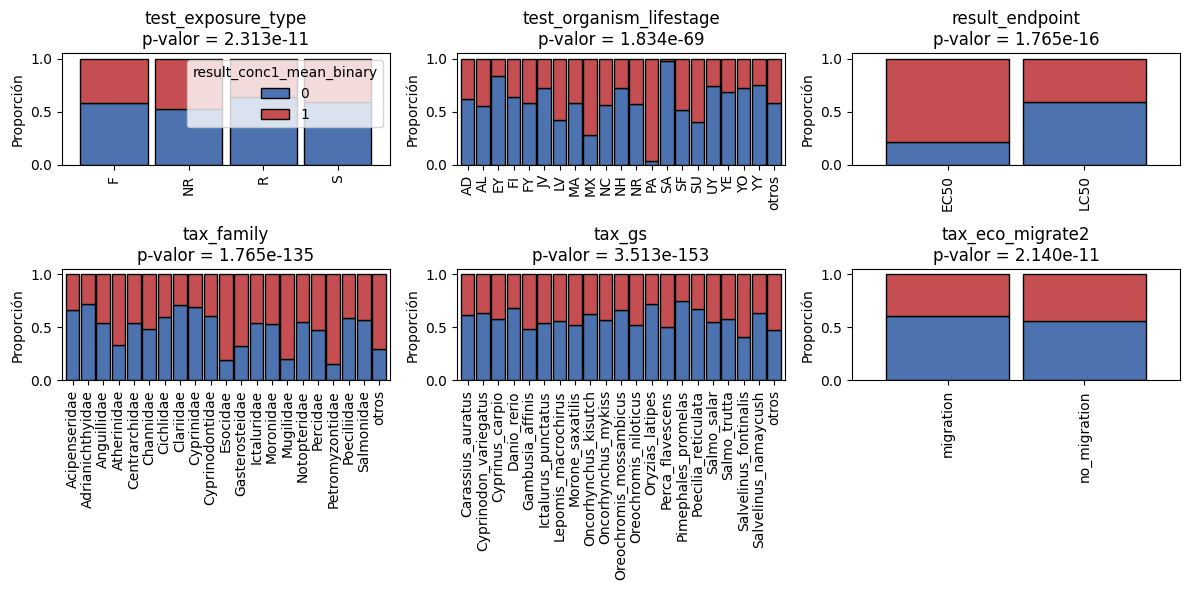

Variable        p_valor
0                   tax_gs  3.512564e-153
1               tax_family  1.764993e-135
2  test_organism_lifestage   1.833949e-69
3          result_endpoint   1.765422e-16
4         tax_eco_migrate2   2.140495e-11
5       test_exposure_type   2.313329e-11

In [57]:
resultados_cat = eda.plot_cat_grouped(
    df=df_modelo,
    variables=vars_cat_analizar,
    target="result_conc1_mean_binary",
    n_cols=3,
    figsize_per_plot=(4, 3),
    max_categories=20  
)
display(resultados_cat)

#### Selecci√≥n final de variables categ√≥ricas para modelado

Tras analizar cada variable categ√≥rica frente al target `result_conc1_mean_binary` mediante test chi-cuadrado, visualizaciones proporcionales y distribuci√≥n univariante, se aplicaron los siguientes criterios de selecci√≥n:

- **Significancia estad√≠stica** (`p < 0.05`)
- **Discriminaci√≥n visual clara entre clases**
- **Cardinalidad razonable o agrupada**
- **No redundancia con otras variables**

#### Variables seleccionadas para el modelo

| Variable                 | Seleccionada | Justificaci√≥n                                                                 |
|--------------------------|--------------|-------------------------------------------------------------------------------|
| `test_exposure_type`     | S√≠        | Informativa, altamente significativa y con pocas categor√≠as                  |
| `test_organism_lifestage`| S√≠        | Significativa; se considerar√° simplificaci√≥n si hay ruido                    |
| `result_endpoint`        | S√≠        | Binaria, discriminativa y clara                                              |
| `tax_family`             | S√≠        | Resume bien la taxonom√≠a con cardinalidad manejable                          |
| `tax_eco_migrate2`       | S√≠        | Binaria, con asociaci√≥n clara con el target                                  |
| `tax_gs`                 | **No**        | Alta cardinalidad, redundante con `tax_family`, riesgo de sobreajuste       |


# Guardado final de features
[Indice](#indice)

In [58]:
# 1. Features preseleccionadas (predictivas)
features_preseleccionadas = [
    # Descriptores moleculares y embeddings
    "chem_mordred_Zagreb1",
    "chem_mordred_TSRW10",
    "chem_mordred_ATSC0d",
    "chem_mordred_TMWC10",
    "chem_mordred_mZagreb2",
    "chem_mordred_ATS3Z",        
    "chem_mordred_Xpc-6dv",
    "chem_mordred_Xpc-5dv",
    "chem_mordred_Xpc-6d",
    "chem_mordred_Sm",
    "chem_mordred_SRW02",
    "chem_mordred_SRW04",
    "chem_mordred_SRW06",
    "chem_mordred_MWC07",
    "chem_mordred_MWC08",
    "chem_mordred_MWC09",
    "chem_mordred_MWC10",
    "chem_mordred_ATS0m",
    "chem_mordred_GGI2",
    "chem_mordred_MPC8",        
    "chem_mol2vec057",

    # Variables categ√≥ricas relevantes
    "test_exposure_type",
    "test_organism_lifestage",
    "result_endpoint",
    "tax_family",
    "tax_eco_migrate2"
]


# 2. Features contextuales (no predictivas directas, pero √∫tiles)
features_contextuales = [
    "media_ph_mean", "media_temperature_mean",      # condiciones ambientales
    "tax_lh_licm", "tax_lh_amd",                     # taxon√≥micas/filogen√©ticas
    "tax_lh_lpcm", "tax_lh_ri#/d"                    # taxon√≥micas/filogen√©ticas
]

# 3. Crear DataFrame con etiquetas
df_features_finales = pd.DataFrame({
    "Variable": features_preseleccionadas + features_contextuales,
    "Tipo": ["predictiva"] * len(features_preseleccionadas) + ["contextual"] * len(features_contextuales)
})

# 4. Mostrar resumen
print(f"Total de variables: {len(df_features_finales)}")
display(df_features_finales)

# 5. Guardar CSV limpio 
df_features_finales.to_csv("../../data/processed/features_seleccionadas.csv", index=False)


Total de variables: 32


Variable        Tipo
0      chem_mordred_Zagreb1  predictiva
1       chem_mordred_TSRW10  predictiva
2       chem_mordred_ATSC0d  predictiva
3       chem_mordred_TMWC10  predictiva
4     chem_mordred_mZagreb2  predictiva
5        chem_mordred_ATS3Z  predictiva
6      chem_mordred_Xpc-6dv  predictiva
7      chem_mordred_Xpc-5dv  predictiva
8       chem_mordred_Xpc-6d  predictiva
9           chem_mordred_Sm  predictiva
10       chem_mordred_SRW02  predictiva
11       chem_mordred_SRW04  predictiva
12       chem_mordred_SRW06  predictiva
13       chem_mordred_MWC07  predictiva
14       chem_mordred_MWC08  predictiva
15       chem_mordred_MWC09  predictiva
16       chem_mordred_MWC10  predictiva
17       chem_mordred_ATS0m  predictiva
18        chem_mordred_GGI2  predictiva
19        chem_mordred_MPC8  predictiva
20          chem_mol2vec057  predictiva
21       test_exposure_type  predictiva
22  test_organism_lifestage  predictiva
23          result_endpoint  predictiva
24               tax_family  predictiva
25         tax_eco_migrate2  predictiva
26            media_ph_mean  contextual
27   media_temperature_mean  contextual
28              tax_lh_licm  contextual
29               tax_lh_amd  contextual
30              tax_lh_lpcm  contextual
31             tax_lh_ri#/d  contextual

## Definici√≥n: 

### Variables predictivas

| Variable                      | Tipo       | Categor√≠a   | Definici√≥n ecotoxicol√≥gica relevante                                                                 |
|------------------------------|------------|-------------|-------------------------------------------------------------------------------------------------------|
| chem_mordred_*               | Predictiva | Num√©rica    | Descriptores moleculares calculados autom√°ticamente (Mordred); codifican estructura y propiedades fisicoqu√≠micas de la mol√©cula. Pueden incluir conectividad, masa, electronegatividad, etc. |
| chem_mol2vec057              | Predictiva | Num√©rica    | Vector embedding generado por Mol2vec; representa la estructura qu√≠mica como vector en espacio latente, √∫til para capturar patrones moleculares complejos. |
| test_exposure_type           | Predictiva | Categ√≥rica  | Tipo de exposici√≥n aplicada en el experimento (est√°tica, flujo continuo, renovaci√≥n, etc.); influye en la biodisponibilidad del t√≥xico. |
| test_organism_lifestage      | Predictiva | Categ√≥rica  | Etapa del ciclo de vida del organismo durante el test (larva, juvenil, adulto); la sensibilidad a t√≥xicos var√≠a seg√∫n el desarrollo. |
| result_endpoint              | Predictiva | Categ√≥rica  | Tipo de medida toxicol√≥gica empleada (e.g., EC50, LC50); define el tipo de efecto agudo medido: mortalidad o inhibici√≥n. |
| tax_family                   | Predictiva | Categ√≥rica  | Familia taxon√≥mica del organismo usado en el test; refleja similitudes evolutivas y fisiol√≥gicas que afectan su sensibilidad. |
| tax_eco_migrate2             | Predictiva | Categ√≥rica  | Comportamiento migratorio del organismo (migratorio vs. sedentario); puede afectar su exposici√≥n ambiental real a t√≥xicos. |

### Variables contextuales

| Variable                      | Tipo        | Categor√≠a   | Definici√≥n ecotoxicol√≥gica relevante                                                                  |
|------------------------------|-------------|-------------|--------------------------------------------------------------------------------------------------------|
| media_ph_mean                | Contextual  | Num√©rica    | Valor medio del pH durante el experimento; el pH puede alterar la toxicidad efectiva de muchas sustancias qu√≠micas. |
| media_temperature_mean       | Contextual  | Num√©rica    | Temperatura media del agua; influye en la toxicocin√©tica y toxicodin√°mica de las sustancias en los peces. |
| tax_lh_licm                  | Contextual  | Num√©rica    | Descriptor del historial de vida relacionado con longevidad, tama√±o corporal, maduraci√≥n (Life History Traits). |
| tax_lh_amd                   | Contextual  | Num√©rica    | Edad media a la madurez del organismo; afecta su resiliencia poblacional y sensibilidad ecotoxicol√≥gica. |
| tax_lh_lpcm                  | Contextual  | Num√©rica    | Longitud promedio corporal m√°xima del organismo; puede relacionarse con su capacidad de acumulaci√≥n de t√≥xicos. |
| tax_lh_ri#/d                 | Contextual  | Num√©rica    | Ritmo reproductivo estimado (n√∫mero de individuos por d√≠a); refleja la velocidad de renovaci√≥n poblacional. |
